In [ ]:
!pip install tensorflow_addons


     |████████████████████████████████| 1.1 MB 5.4 MB/s 


# Load library

In [ ]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds
import pathlib
import shutil
import tempfile

from  IPython import display
from matplotlib import pyplot as plt
import seaborn as sns

from tensorflow.keras.models import  Model
import tensorflow_addons as tfa
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import  SGD
import os

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5876117836328273078, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11345264640
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7536805038534831699
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

# Read file from drive

In [ ]:
#Read file from drive
from google.colab import drive
drive.mount('/content/drive/')
!cp /content/drive/'My Drive'/COSC2779/COSC2779HW1/A1_data.zip .
!unzip -q -o A1_data.zip
!rm A1_data.zip

Mounted at /content/drive/


drive/      __MACOSX/                 S40AR_test_data.csv
Images/     README.md                 S40AR_train_data.csv
Images.zip  s1234567_predictions.csv  sample_data/


In [ ]:
!unzip -q -o Images.zip

In [ ]:
df = pd.read_csv('./S40AR_train_data.csv')

In [ ]:
df.head()

FileName           action             action_class
0  Img_1000.jpg  walking_the_dog  Interacting_with_animal
1  Img_1001.jpg    riding_a_bike           other_activity
2  Img_1002.jpg        gardening            domestic_work
3  Img_1008.jpg          cooking            domestic_work
4  Img_1010.jpg          jumping           other_activity

In [ ]:
#Create class num to use as input in data generator
action_list = list(df['action'].unique())
actionclass_list = list(df['action_class'].unique())
df['action_num'] = df['action'].apply(action_list.index)
df['action_class_num'] = df['action_class'].apply(actionclass_list.index)

In [ ]:
df.head()

FileName           action  ... action_num  action_class_num
0  Img_1000.jpg  walking_the_dog  ...          0                 0
1  Img_1001.jpg    riding_a_bike  ...          1                 1
2  Img_1002.jpg        gardening  ...          2                 2
3  Img_1008.jpg          cooking  ...          3                 2
4  Img_1010.jpg          jumping  ...          4                 1

[5 rows x 5 columns]

In [ ]:
df.groupby('action_class').count()['FileName']

action_class
Interacting_with_animal       576
domestic_work                 570
other_activity                933
playing_musical_instrument    349
using_comm_device             602
Name: FileName, dtype: int64

In [ ]:
df_x =  df['FileName']
action = df['action_num']
action_class = df['action_class_num']
df_y = pd.concat((action,action_class),axis=1)

In [ ]:
df_y

action_num  action_class_num
0              0                 0
1              1                 1
2              2                 2
3              3                 2
4              4                 1
...          ...               ...
3025           9                 3
3026          11                 0
3027           1                 1
3028           4                 1
3029          16                 4

[3030 rows x 2 columns]

[Text(0, 0, 'walking_the_dog'),
 Text(0, 0, 'riding_a_bike'),
 Text(0, 0, 'gardening'),
 Text(0, 0, 'cooking'),
 Text(0, 0, 'jumping'),
 Text(0, 0, 'cutting_vegetables'),
 Text(0, 0, 'watching_TV'),
 Text(0, 0, 'cleaning_the_floor'),
 Text(0, 0, 'shooting_an_arrow'),
 Text(0, 0, 'texting_message'),
 Text(0, 0, 'playing_violin'),
 Text(0, 0, 'feeding_a_horse'),
 Text(0, 0, 'taking_photos'),
 Text(0, 0, 'washing_dishes'),
 Text(0, 0, 'riding_a_horse'),
 Text(0, 0, 'rowing_a_boat'),
 Text(0, 0, 'playing_guitar'),
 Text(0, 0, 'climbing'),
 Text(0, 0, 'running'),
 Text(0, 0, 'phoning'),
 Text(0, 0, 'using_a_computer')]

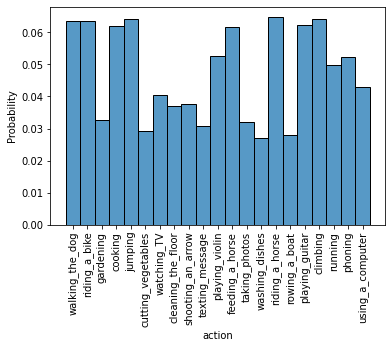

In [ ]:
label2= list(df['action'].unique())
g2 =sns.histplot(data=df, x='action', stat='probability')
g2.set_xticklabels(label2,rotation=90)

[Text(0, 0, 'Interacting_with_animal'),
 Text(0, 0, 'other_activity'),
 Text(0, 0, 'domestic_work'),
 Text(0, 0, 'using_comm_device'),
 Text(0, 0, 'playing_musical_instrument')]

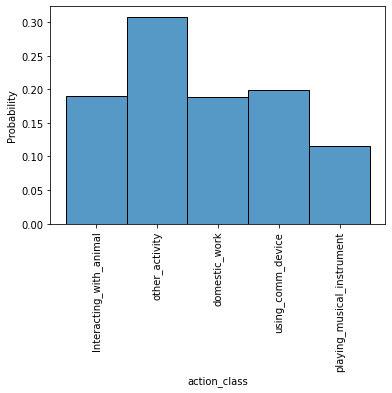

In [ ]:
label2= list(df['action_class'].unique())
g2 =sns.histplot(data=df, x='action_class', stat='probability')
g2.set_xticklabels(label2,rotation=90)

In [ ]:
len(action_list)

21

In [ ]:
df.sample(frac=1)

FileName           action  ... action_num  action_class_num
814   Img_3365.jpg  walking_the_dog  ...          0                 0
2364  Img_7764.jpg          running  ...         18                 1
1630  Img_5630.jpg          phoning  ...         19                 3
1384  Img_4956.jpg   washing_dishes  ...         13                 2
1664  Img_5722.jpg         climbing  ...         17                 1
...            ...              ...  ...        ...               ...
2097  Img_6947.jpg  walking_the_dog  ...          0                 0
893   Img_3581.jpg          jumping  ...          4                 1
897   Img_3603.jpg          running  ...         18                 1
659   Img_2902.jpg        gardening  ...          2                 2
2290  Img_7530.jpg        gardening  ...          2                 2

[3030 rows x 5 columns]

In [ ]:
#train-test split 80-20
np.random.seed(0)
from sklearn.model_selection import train_test_split
X_train1, X_test,y_train1, y_test = train_test_split(df_x, df_y, test_size=0.1, shuffle=True,stratify= df_y)
X_train, X_val,y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.111, shuffle=True,stratify= y_train1)

In [ ]:
train_df =  pd.concat((X_train,y_train),axis=1)
val_df = pd.concat((X_val,y_val),axis=1)
test_df = pd.concat((X_test,y_test),axis=1)
print("train: ",train_df.shape," val: ", val_df.shape,"test: ",test_df.shape)

train:  (2424, 3)  val:  (303, 3) test:  (303, 3)


In [ ]:
train_df['action_class_num'].value_counts(normalize=True)

1    0.308168
3    0.198845
0    0.189769
2    0.188119
4    0.115099
Name: action_class_num, dtype: float64

In [ ]:
val_df['action_class_num'].value_counts(normalize=True)

1    0.306931
3    0.198020
0    0.191419
2    0.188119
4    0.115512
Name: action_class_num, dtype: float64

In [ ]:
test_df['action_class_num'].value_counts(normalize=True)

1    0.306931
3    0.198020
0    0.191419
2    0.188119
4    0.115512
Name: action_class_num, dtype: float64

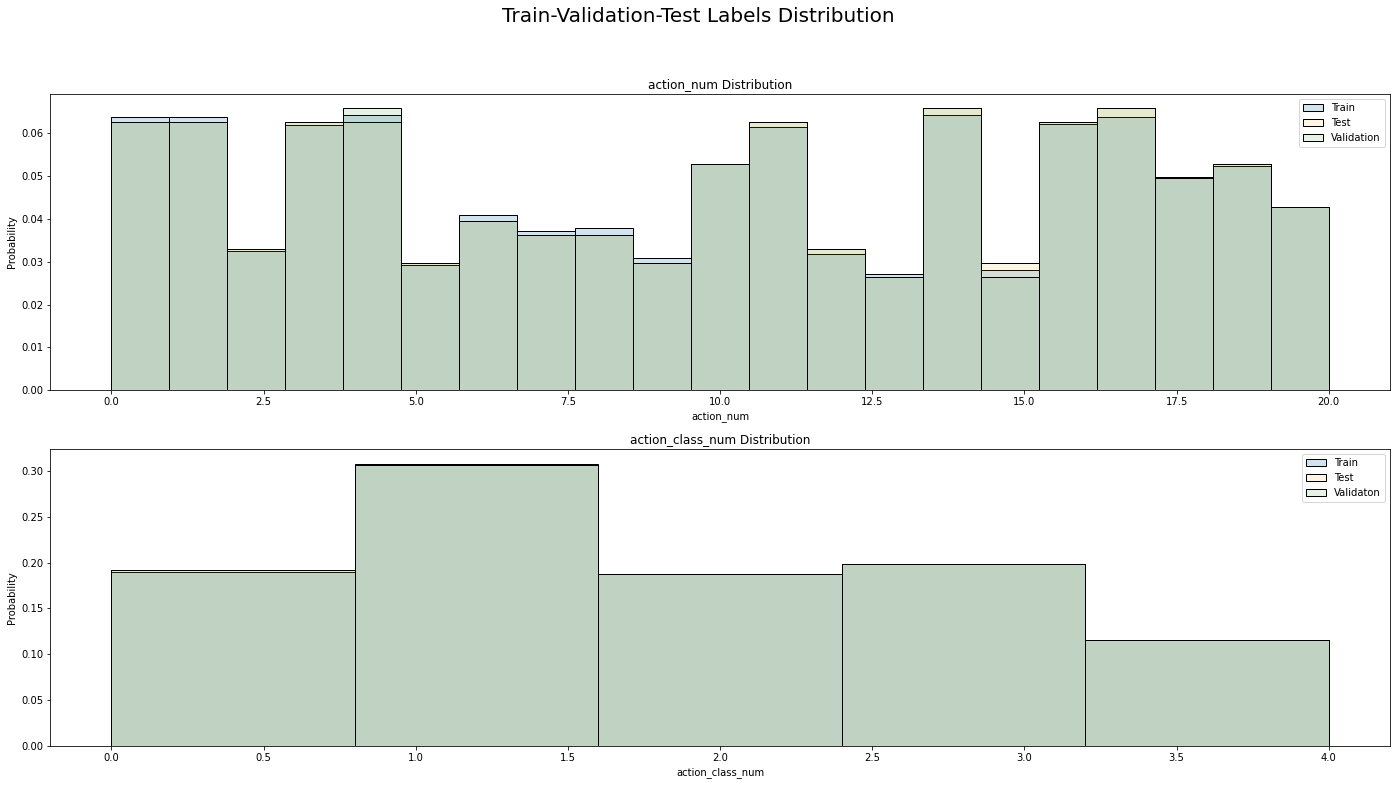

In [ ]:
fig, (ax1, ax2)= plt.subplots(nrows=2, figsize=(24,12))

sns.histplot(data=train_df, x='action_num', stat='probability', alpha=0.2, ax=ax1, label='Train',bins=21)
sns.histplot(data=test_df, x='action_num', stat='probability', alpha=0.1, color='orange', ax=ax1, label='Test',bins=21)
sns.histplot(data=val_df, x='action_num', stat='probability', alpha=0.1, color='green', ax=ax1, label='Validation',bins=21)
ax1.set_title('action_num Distribution')
ax1.legend()

sns.histplot(data=train_df, x='action_class_num', stat='probability', alpha=0.2, ax=ax2, label='Train',bins=5)
sns.histplot(data=test_df, x='action_class_num', stat='probability', alpha=0.1, color='orange', ax=ax2, label='Test',bins=5)
sns.histplot(data=val_df, x='action_class_num', stat='probability', alpha=0.1, color='green', ax=ax2, label='Validaton',bins=5)
ax2.set_title('action_class_num Distribution')
ax2.legend()

fig.suptitle("Train-Validation-Test Labels Distribution", size=20)
fig.show()

## Setup data loader

In [ ]:
import tensorflow.keras as keras
from scipy.interpolate import interp1d
import numpy as np
from scipy.ndimage.interpolation import rotate, shift
from PIL import Image

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_frame, batch_size=8, dim=(224, 224,3), n_action=21, n_action_class=5, data_mean=0, data_std=1,  data_prefix='', shuffle=True, Augment=True):
        'Initialization'
        self.dim = dim  # Dimentions of the input
        self.batch_size = batch_size
        self.n_action = n_action  # Number of classes. This is for a classification task
        self.n_action_class = n_action_class
        
        self.shuffle = shuffle  # Flag to shuffle data at the end of epoch
        self.Augment = Augment  # Falg to augmetn the data

        # The data is input as a pandas dataframe, we need to read the relevent fields
        self.data_frame = data_frame
        #self.image_label = data_frame['labels_num'].values.tolist()
        self.action = data_frame['action_num'].values.tolist()
        self.action_class =  data_frame['action_class_num'].values.tolist()
        self.image_ids = np.arange(len(self.action_class)).tolist()
        self.data_prefix = data_prefix
        
        # Data normalization parameters
        self.data_mean = data_mean
        self.data_std = data_std
        
        self.on_epoch_end()

        self.n = 0
        self.max = self.__len__()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data for the given index'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of IDs
        data_ids_temp = [self.image_ids[k] for k in indexes]
       
        action_temp = [self.action[k] for k in indexes]
       
        action_class_temp = [self.action_class[k] for k in indexes]
      
        # Generate data
        X, y, y_ac = self.__data_generation(data_ids_temp, action_temp,action_class_temp)
        
        return X, {'y_action':y,'y_action_class':y_ac}
    

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
        
    # Support function

    def __data_generation(self, data_ids_temp, action_temp,action_class_temp):
        'Generates data containing batch_size samples' 

        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)
        y_ac = np.empty((self.batch_size), dtype=int)
        

        # Generate data
        for i, ids in enumerate(data_ids_temp):
            #print(ids)
            X[i,] = self.__read_data_instance(data_ids_temp[i])
            y[i] = action_temp[i]
            y_ac[i] = action_class_temp[i]
            
            
        return X, keras.utils.to_categorical(y, num_classes=self.n_action),keras.utils.to_categorical(y_ac, num_classes=self.n_action_class)


    def __read_data_instance(self, pid):
      # Read an image
      filepath = self.data_prefix + self.data_frame.iloc[pid]['FileName']
      
      data = Image.open(filepath)
      data = data.resize((224,224))
      data = np.asarray(data)


      if self.Augment:
          rot = np.random.rand(1) < 0.5
          if rot:
              rot = np.random.randint(-10,10, size=1)
              data = rotate(data, angle=rot[0], reshape=False)
          
          shift_val = np.random.randint(-5, high=5, size=2, dtype=int).tolist() + [0,]
          data = shift(data, shift_val, order=0, mode='constant', cval=0.0, prefilter=False)

      X = data

      # Input normalization
      X = (X - self.data_mean)/self.data_std
      return X


    #make data loader iterable
    def __next__(self):
        if self.n >= self.max:
           self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result

In [ ]:

data_mean = 0.
data_std = 255.0
prefix='./Images/'
training_generator = DataGenerator(train_df,dim=(224, 224,3), batch_size=32, data_mean=data_mean, 
                                   data_std=data_std, n_action=21, n_action_class=5, Augment=False, data_prefix=prefix)
validation_generator = DataGenerator(val_df,dim=(224, 224,3), batch_size=32, data_mean=data_mean, 
                                   data_std=data_std, n_action=21, n_action_class=5, Augment=False, data_prefix=prefix)


test_generator = DataGenerator(test_df,dim=(224, 224,3), batch_size=1, data_mean=data_mean, 
                                   data_std=data_std, n_action=21, n_action_class=5, Augment=False, data_prefix=prefix,shuffle=False)


validation_generator_performance = DataGenerator(val_df,dim=(224, 224,3), batch_size=1, data_mean=data_mean, 
                                   data_std=data_std, n_action=21, n_action_class=5, Augment=False, data_prefix=prefix,shuffle=False)

augment_generator = DataGenerator(train_df,dim=(224, 224,3), batch_size=32, data_mean=data_mean, 
                                   data_std=data_std, n_action=21, n_action_class=5, Augment=True, data_prefix=prefix)

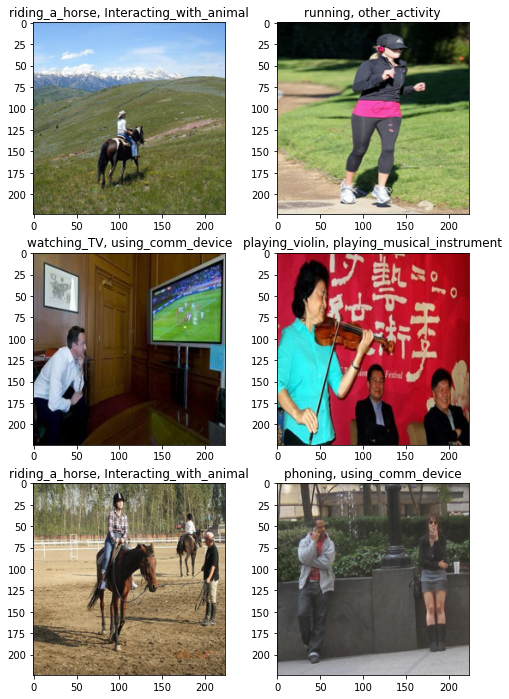

In [ ]:
aciton_names = {0: action_list[0], 1: action_list[1], 2: action_list[2], 3: action_list[3], 4: action_list[4], 5: action_list[5], 6: action_list[6], 7: action_list[7],
                8: action_list[8], 9: action_list[9],10:action_list[10],11:action_list[11],12:action_list[12],13:action_list[13],14:action_list[14],15:action_list[15],
                16:action_list[16],17:action_list[17],18:action_list[18],19:action_list[19],20:action_list[20]}
class_name = {0:actionclass_list[0],1:actionclass_list[1],2:actionclass_list[2],3:actionclass_list[3],4:actionclass_list[4]}
plt.figure(figsize=(8,12))
for k in training_generator.__iter__():
  j =0
  for i in zip(k[0],k[1]['y_action'],k[1]['y_action_class']):
    plt.subplot(3,2,j+1)
    plt.imshow(i[0])
    plt.title(aciton_names[np.argmax(i[1])]+", "+class_name[np.argmax(i[2])])
    j+=1
    if j ==6:
      break
  break

## Developing the Models

In [ ]:
class ResidualBlock(tf.keras.layers.Layer):

    # Initialize components of the model
    def __init__(self, filter_num, stride=1, reg_lambda=0.0):
        super(ResidualBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            kernel_initializer="he_normal",
                                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization(momentum=.4)
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=1,
                                            kernel_initializer="he_normal",
                                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                            padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization(momentum=.4)
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                       kernel_size=(1, 1),
                                                       kernel_initializer="he_normal",
                                                       kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                                       strides=stride))
            self.downsample.add(tf.keras.layers.BatchNormalization(momentum=.4))
        else:
            self.downsample = lambda x: x

    # Define the forward function
    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'conv1': self.conv1,
            'bn1': self.bn1,
            'conv2': self.conv2,
            'bn2': self.bn2,
            'downsample': self.downsample,
        })
        return config

In [ ]:
def get_resnet_model(filters, block_size, reg_lambda=0.0, fdropout=False,input_shape = 64):
  input = tf.keras.layers.Input(shape=(input_shape, input_shape, 3))


  x = tf.keras.layers.Conv2D(filters=64,
                                   kernel_size=(7, 7),
                                   strides=1,
                                   kernel_initializer="he_normal",
                                   kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                   padding="same")(input)

  x = tf.keras.layers.BatchNormalization(momentum=.4)(x)

  #Stack of residual blocks
  for nFilters, nBlocks in zip(filters, block_size):
    x = ResidualBlock(nFilters, stride=2, reg_lambda=reg_lambda)(x)
    
    for _ in range(1, nBlocks):
     x = ResidualBlock(nFilters, stride=1, reg_lambda=reg_lambda)(x)

  # final part
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Flatten()(x)
  y_action = tf.keras.layers.Dense(21,activation=tf.nn.softmax,
                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                            kernel_initializer="he_normal",name='y_action')(x)
  y_action_class = tf.keras.layers.Dense(5,activation=tf.nn.softmax,
                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                            kernel_initializer="he_normal",name ='y_action_class')(x)
  
  model = Model(inputs=input, outputs=[y_action, y_action_class]) 

  return model

## Utility function

In [ ]:
from keras.callbacks import ModelCheckpoint
def get_callbacks(name):
  checkpoint = './drive/My Drive/training_checkpoints'
  #checkpoint_filepath = os.path.join(checkpoint, "checkpoint_{epoch:02d}")
  checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_{epoch:02d}")
  model_checkpoint_callback = ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            save_best_only=False)
  return model_checkpoint_callback

In [ ]:
#For plot train-validation loss and f1 score
def plot_validation_performance(history, recall_num=''):
    history_frame = pd.DataFrame(history.history)
    fig, (ax1, ax2, ax3,ax4)= plt.subplots(ncols=4, figsize=(18,4))

    history_frame.loc[:, ['y_action_loss', 'val_y_action_loss']].plot(ax = ax1)
    history_frame.loc[:, ['y_action_class_loss', 'val_y_action_class_loss' + recall_num]].plot(ax = ax2)
    history_frame.loc[:, ['y_action_f1_score', 'val_y_action_f1_score']].plot(ax = ax3)
    history_frame.loc[:, ['y_action_class_f1_score', 'val_y_action_class_f1_score']].plot(ax = ax4)

    ax1.set_title("y_action_loss", size=14)
    ax2.set_title("y_action_class_loss", size=14)
    ax3.set_title("y_action_f1_score", size=14)
    ax4.set_title("y_action_class_f1_score", size=14)

    fig.suptitle("Train-Validation Performance Comparison", size=18, y= 1.05)

    fig.show()

In [ ]:
# to return classification report and confusion matrix of action class task
def performance_class(model,test_generator,actionclass_list):
  y = model.predict(test_generator)
  #action_pred = np.argmax(y[0],axis=1)
  class_pred = np.argmax(y[1],axis=1)

  #action_true = test_generator.action
  class_true = test_generator.action_class

  print(classification_report(class_true, class_pred))

  #action_names = action_list
  class_name = actionclass_list

  disp=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(class_true, class_pred,normalize = 'true'), 
                                  display_labels=list(class_name))

  disp.plot()

# to return classification report and confusion matrix of action task
def performance_action(model,test_generator,action_list):
  y = model.predict(test_generator)
  action_pred = np.argmax(y[0],axis=1)
  #class_pred = np.argmax(y[1],axis=1)

  action_true = test_generator.action
  #class_true = test_generator.action_class

  print(classification_report(action_true, action_pred))

  #action_names = action_list
  action_name = action_list

  disp=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(action_true, action_pred,normalize = 'true'), 
                                  display_labels=list(action_name))
  fig, ax = plt.subplots(figsize=(10,10))

  disp.plot(ax=ax)

# to combine training generator and augmentation generator  
def combine_gen(gens):
    while True:
        for g in gens:
            yield next(g)

# Tiny model test

use to test utility function and data generator

In [ ]:
num_train_examples = 2424
num_val_examples = 303
BATCH_SIZE = 32

tiny_res_net = get_resnet_model([64,], [1,])
tiny_res_net.compile(#optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum= 0.9),
                     optimizer='SGD',
                     loss={'y_action': 'categorical_crossentropy', 'y_action_class': 'categorical_crossentropy'},
                     metrics={'y_action': tfa.metrics.F1Score(num_classes=21, average='macro'),
                    'y_action_class': tfa.metrics.F1Score(num_classes=5, average='macro')})


In [ ]:
epochs = 50
history_tiny= tiny_res_net.fit(training_generator,epochs=epochs,#steps_per_epoch=num_train_examples//BATCH_SIZE, 
                  validation_data=validation_generator,
                  #validation_steps=num_val_examples//BATCH_SIZE,  
                  callbacks=[get_callbacks('models/resnet_tiny_dataset')])

Epoch 1/50
75/75 [==============================] - 66s 275ms/step - loss: 4.6438 - y_action_loss: 3.1014 - y_action_class_loss: 1.5424 - y_action_f1_score: 0.0372 - y_action_class_f1_score: 0.2665 - val_loss: 4.4481 - val_y_action_loss: 3.0095 - val_y_action_class_loss: 1.4386 - val_y_action_f1_score: 0.0257 - val_y_action_class_f1_score: 0.2271
Epoch 2/50
75/75 [==============================] - 20s 272ms/step - loss: 4.4339 - y_action_loss: 2.9714 - y_action_class_loss: 1.4626 - y_action_f1_score: 0.0445 - y_action_class_f1_score: 0.2464 - val_loss: 4.3251 - val_y_action_loss: 2.9321 - val_y_action_class_loss: 1.3930 - val_y_action_f1_score: 0.0412 - val_y_action_class_f1_score: 0.2513
Epoch 3/50
75/75 [==============================] - 21s 276ms/step - loss: 4.3569 - y_action_loss: 2.9198 - y_action_class_loss: 1.4371 - y_action_f1_score: 0.0542 - y_action_class_f1_score: 0.2705 - val_loss: 4.2493 - val_y_action_loss: 2.8815 - val_y_action_class_loss: 1.3677 - val_y_action_f1_score

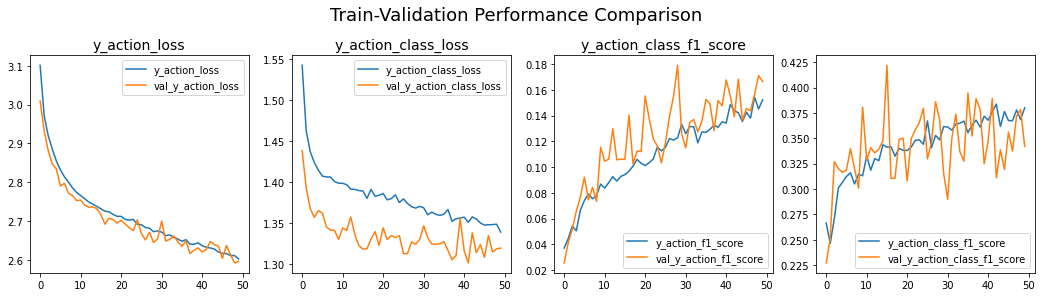

In [ ]:
plot_validation_performance(history_tiny)

In [ ]:
def performance_validation(mdl, test_generator, model_name):
    
    print(model_name)
    print("==============================================")
    
    y_true=np.array(test_generator.labels)
    y_pred=np.argmax(mdl.predict(test_generator), axis=1)
    
    print(classification_report(y_true, y_pred))

    label_names = test_generator.class_indices

    disp=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred,normalize = 'true'), 
                                display_labels=list(label_names.keys()))
    disp.plot()
    
    return (y_true, y_pred)

In [ ]:
name = 'models/resnet_tiny_dataset'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_49")
tiny_res_net.load_weights(checkpoint_filepath)

              precision    recall  f1-score   support

           0       0.40      0.21      0.27        58
           1       0.46      0.71      0.55        93
           2       0.41      0.26      0.32        57
           3       0.42      0.47      0.44        60
           4       0.36      0.26      0.30        35

    accuracy                           0.43       303
   macro avg       0.41      0.38      0.38       303
weighted avg       0.42      0.43      0.41       303



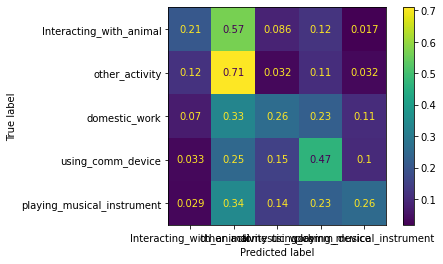

In [ ]:
performance_class(tiny_res_net,validation_generator_performance,actionclass_list)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.30      0.42      0.35        19
           1       0.15      0.16      0.15        19
           2       0.33      0.10      0.15        10
           3       0.14      0.11      0.12        19
           4       0.30      0.55      0.39        20
           5       0.40      0.22      0.29         9
           6       0.67      0.17      0.27        12
           7       0.07      0.09      0.08        11
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00         9
          10       0.25      0.12      0.17        16
          11       0.17      0.16      0.16        19
          12       0.50      0.10      0.17        10
          13       0.00      0.00      0.00         8
          14       0.33      0.40      0.36        20
          15       0.50      0.25      0.33         8
          16       0.19      0.47      0.27        19
          17       0.14    

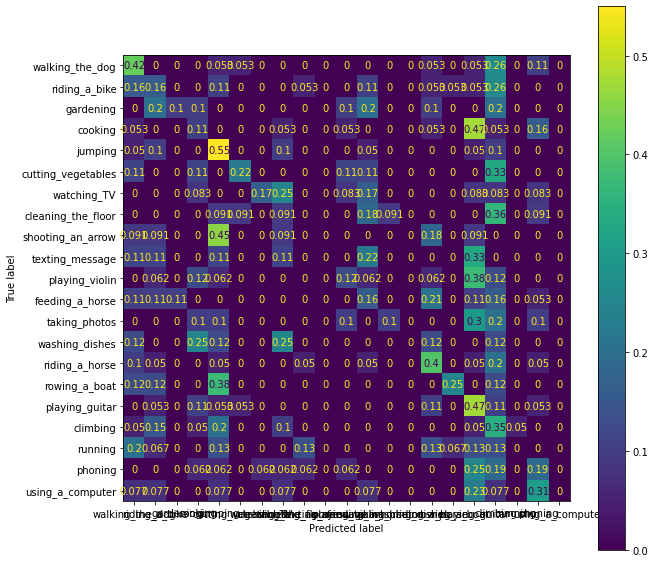

In [ ]:
performance_action(tiny_res_net,validation_generator_performance,action_list)

# Base Model (resnet-34)


* I decided to use macro-F1 score as evalution matrics for both tasks because, it make all class equally important and not bias too much on majority class.

In [ ]:
base_model = get_resnet_model([64,128,256,512], [3,4,6,3])
base_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum= 0.9),
                     #optimizer='SGD',
                     loss={'y_action': 'categorical_crossentropy', 'y_action_class': 'categorical_crossentropy'},
                     metrics={'y_action': tfa.metrics.F1Score(num_classes=21, average='macro'),
                    'y_action_class': tfa.metrics.F1Score(num_classes=5, average='macro')})

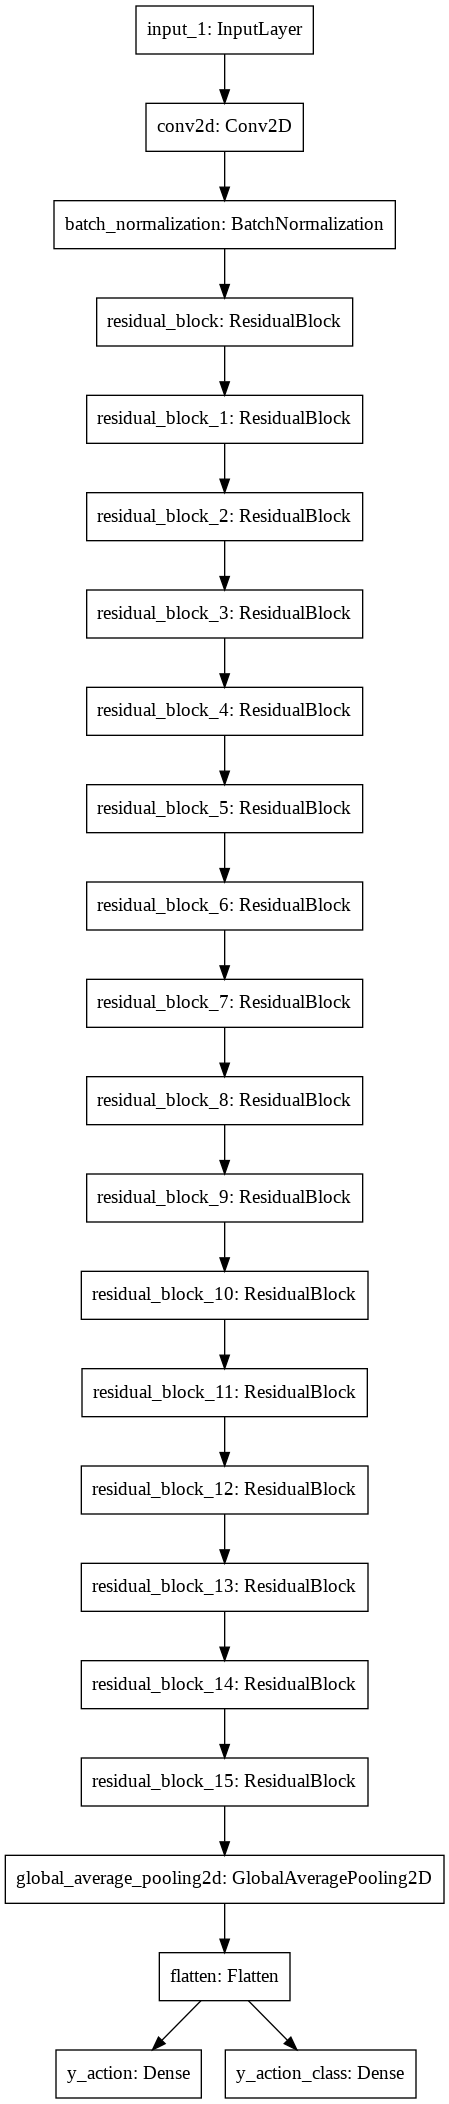

In [ ]:
tf.keras.utils.plot_model(base_model)

In [ ]:
epochs = 30
history_base= base_model.fit(training_generator,epochs=epochs,#steps_per_epoch=num_train_examples//BATCH_SIZE, 
                  validation_data=validation_generator,
                  #validation_steps=num_val_examples//BATCH_SIZE,  
                  callbacks=[get_callbacks('models/resnet_base')])

Epoch 1/30
75/75 [==============================] - 145s 1s/step - loss: 5.0589 - y_action_loss: 3.3702 - y_action_class_loss: 1.6887 - y_action_f1_score: 0.0580 - y_action_class_f1_score: 0.2796 - val_loss: 4.3541 - val_y_action_loss: 2.8741 - val_y_action_class_loss: 1.4800 - val_y_action_f1_score: 0.0583 - val_y_action_class_f1_score: 0.3296
Epoch 2/30
75/75 [==============================] - 105s 1s/step - loss: 4.2861 - y_action_loss: 2.8206 - y_action_class_loss: 1.4655 - y_action_f1_score: 0.0955 - y_action_class_f1_score: 0.3433 - val_loss: 4.3037 - val_y_action_loss: 2.8407 - val_y_action_class_loss: 1.4630 - val_y_action_f1_score: 0.0983 - val_y_action_class_f1_score: 0.2745
Epoch 3/30
75/75 [==============================] - 105s 1s/step - loss: 4.0995 - y_action_loss: 2.7162 - y_action_class_loss: 1.3833 - y_action_f1_score: 0.1233 - y_action_class_f1_score: 0.3582 - val_loss: 6.0866 - val_y_action_loss: 3.7727 - val_y_action_class_loss: 2.3139 - val_y_action_f1_score: 0.08

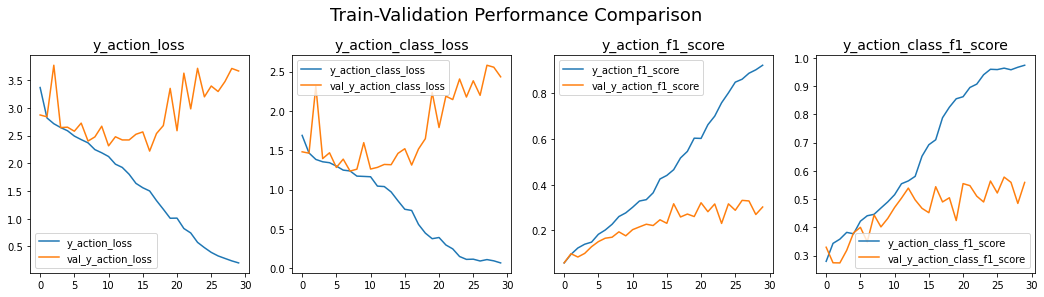

In [ ]:
plot_validation_performance(history_base)

* Overfitting veryfast 


### Validation performance

In [ ]:
name = 'models/resnet_base'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_27")
base_model.load_weights(checkpoint_filepath)

              precision    recall  f1-score   support

           0       0.57      0.67      0.61        58
           1       0.65      0.78      0.71        93
           2       0.62      0.37      0.46        57
           3       0.57      0.60      0.59        60
           4       0.64      0.46      0.53        35

    accuracy                           0.61       303
   macro avg       0.61      0.58      0.58       303
weighted avg       0.61      0.61      0.60       303



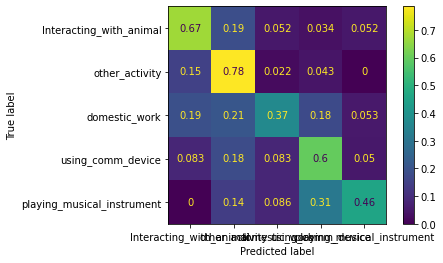

In [ ]:
performance_class(base_model,validation_generator_performance,actionclass_list)

              precision    recall  f1-score   support

           0       0.43      0.53      0.48        19
           1       0.67      0.53      0.59        19
           2       0.38      0.50      0.43        10
           3       0.25      0.16      0.19        19
           4       0.53      0.50      0.51        20
           5       0.29      0.22      0.25         9
           6       0.57      0.33      0.42        12
           7       0.22      0.36      0.28        11
           8       0.40      0.18      0.25        11
           9       0.12      0.33      0.18         9
          10       0.67      0.25      0.36        16
          11       0.53      0.47      0.50        19
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00         8
          14       0.57      0.60      0.59        20
          15       0.44      0.50      0.47         8
          16       0.46      0.58      0.51        19
          17       0.45    

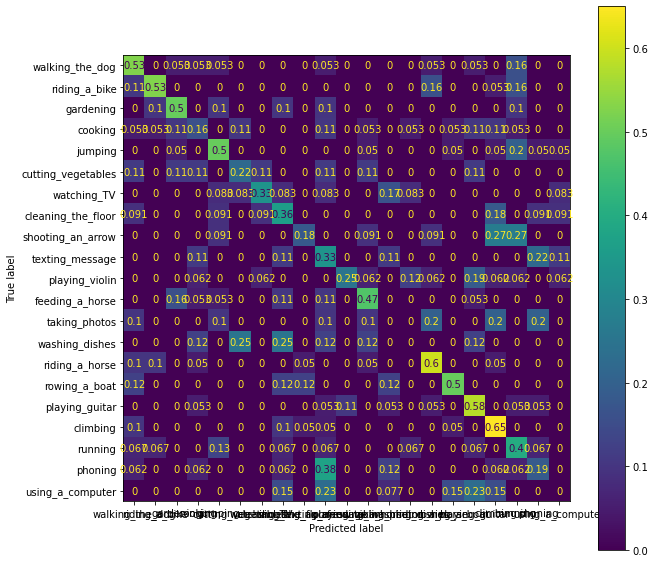

In [ ]:
performance_action(base_model,validation_generator_performance,action_list)

### Test performance

              precision    recall  f1-score   support

           0       0.46      0.60      0.52        58
           1       0.65      0.71      0.68        93
           2       0.51      0.39      0.44        57
           3       0.52      0.58      0.55        60
           4       0.67      0.29      0.40        35

    accuracy                           0.55       303
   macro avg       0.56      0.51      0.52       303
weighted avg       0.56      0.55      0.55       303



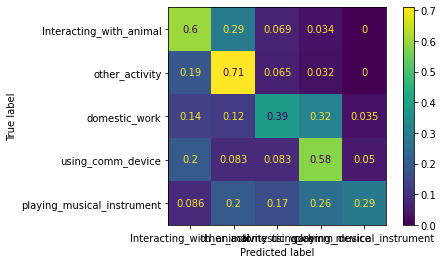

In [ ]:
performance_class(base_model,test_generator,actionclass_list)

              precision    recall  f1-score   support

           0       0.31      0.42      0.36        19
           1       0.78      0.37      0.50        19
           2       0.23      0.30      0.26        10
           3       0.30      0.37      0.33        19
           4       0.36      0.47      0.41        19
           5       0.33      0.22      0.27         9
           6       0.43      0.25      0.32        12
           7       0.27      0.27      0.27        11
           8       0.00      0.00      0.00        11
           9       0.03      0.11      0.05         9
          10       0.40      0.12      0.19        16
          11       0.36      0.26      0.30        19
          12       0.11      0.10      0.11        10
          13       0.10      0.12      0.11         8
          14       0.44      0.60      0.51        20
          15       1.00      0.22      0.36         9
          16       0.50      0.37      0.42        19
          17       0.48    

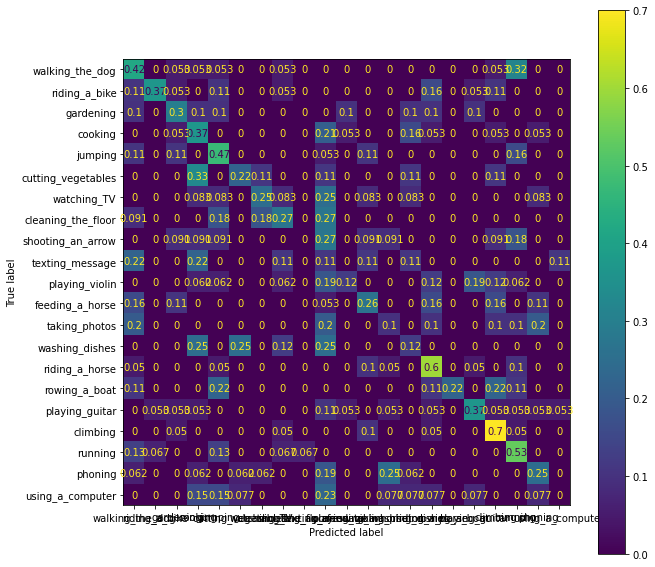

In [ ]:
performance_action(base_model,test_generator,action_list)

* Test performance of base model is **0.52 macro-f1 score** of action class classification task and **0.29 macro-f1 score** on action classification.

#Augmentation

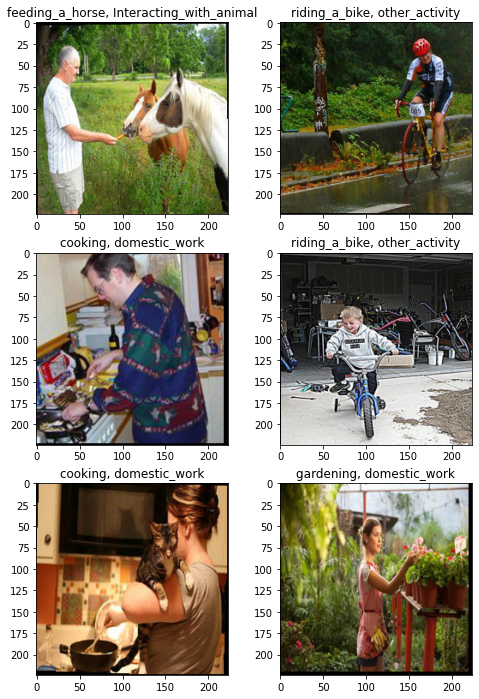

In [ ]:
aciton_names = {0: action_list[0], 1: action_list[1], 2: action_list[2], 3: action_list[3], 4: action_list[4], 5: action_list[5], 6: action_list[6], 7: action_list[7],
                8: action_list[8], 9: action_list[9],10:action_list[10],11:action_list[11],12:action_list[12],13:action_list[13],14:action_list[14],15:action_list[15],
                16:action_list[16],17:action_list[17],18:action_list[18],19:action_list[19],20:action_list[20]}
class_name = {0:actionclass_list[0],1:actionclass_list[1],2:actionclass_list[2],3:actionclass_list[3],4:actionclass_list[4]}
plt.figure(figsize=(8,12))
for k in augment_generator.__iter__():
  j =0
  for i in zip(k[0],k[1]['y_action'],k[1]['y_action_class']):
    plt.subplot(3,2,j+1)
    plt.imshow(i[0])
    plt.title(aciton_names[np.argmax(i[1])]+", "+class_name[np.argmax(i[2])])
    j+=1
    if j ==6:
      break
  break

## Resnet34

In [ ]:
resnet_34_aug_model = get_resnet_model([64,128,256,512], [3,4,6,3])
resnet_34_aug_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum= 0.9),
                     #optimizer='SGD',
                     loss={'y_action': 'categorical_crossentropy', 'y_action_class': 'categorical_crossentropy'},
                     metrics={'y_action': tfa.metrics.F1Score(num_classes=21, average='macro'),
                    'y_action_class': tfa.metrics.F1Score(num_classes=5, average='macro')})

In [ ]:
gen_list = [training_generator,augment_generator]
epochs = 40
history_resnet_34_aug= resnet_34_aug_model.fit(combine_gen(gen_list),epochs=epochs,steps_per_epoch=len(training_generator)*len(gen_list), 
                  validation_data=validation_generator,
                  validation_steps=len(validation_generator),  
                  callbacks=[get_callbacks('models/resnet_34_aug')])

Epoch 1/40
150/150 [==============================] - 240s 1s/step - loss: 4.8846 - y_action_loss: 3.1217 - y_action_class_loss: 1.7629 - y_action_f1_score: 0.0924 - y_action_class_f1_score: 0.2913 - val_loss: 4.3486 - val_y_action_loss: 2.7902 - val_y_action_class_loss: 1.5584 - val_y_action_f1_score: 0.0751 - val_y_action_class_f1_score: 0.2787
Epoch 2/40
150/150 [==============================] - 200s 1s/step - loss: 4.0606 - y_action_loss: 2.6606 - y_action_class_loss: 1.4000 - y_action_f1_score: 0.1480 - y_action_class_f1_score: 0.3607 - val_loss: 3.9774 - val_y_action_loss: 2.5954 - val_y_action_class_loss: 1.3820 - val_y_action_f1_score: 0.1354 - val_y_action_class_f1_score: 0.3066
Epoch 3/40
150/150 [==============================] - 200s 1s/step - loss: 3.7582 - y_action_loss: 2.4518 - y_action_class_loss: 1.3064 - y_action_f1_score: 0.2082 - y_action_class_f1_score: 0.4100 - val_loss: 3.7993 - val_y_action_loss: 2.4582 - val_y_action_class_loss: 1.3412 - val_y_action_f1_score

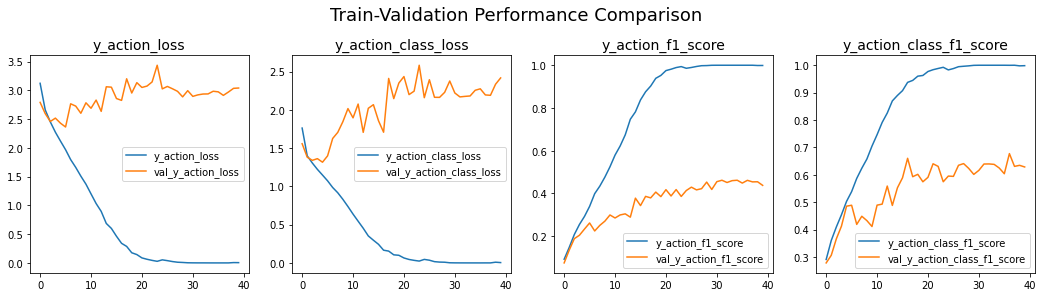

In [ ]:
plot_validation_performance(history_resnet_34_aug)

In [ ]:
name = 'models/resnet_34_aug'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_37")
resnet_34_aug_model.load_weights(checkpoint_filepath)

### Validation performance

              precision    recall  f1-score   support

           0       0.74      0.60      0.67        58
           1       0.71      0.70      0.71        93
           2       0.54      0.63      0.58        57
           3       0.61      0.65      0.63        60
           4       0.76      0.74      0.75        35

    accuracy                           0.66       303
   macro avg       0.67      0.67      0.67       303
weighted avg       0.67      0.66      0.67       303



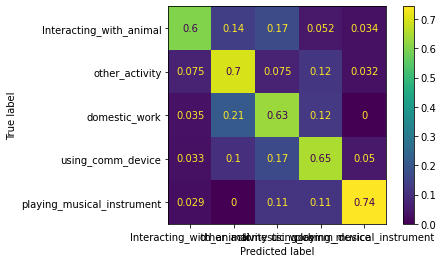

In [ ]:
performance_class(resnet_34_aug_model,validation_generator_performance,actionclass_list)

              precision    recall  f1-score   support

           0       0.56      0.53      0.54        19
           1       0.80      0.84      0.82        19
           2       0.28      0.50      0.36        10
           3       0.44      0.58      0.50        19
           4       0.50      0.50      0.50        20
           5       0.14      0.11      0.12         9
           6       0.60      0.25      0.35        12
           7       0.38      0.27      0.32        11
           8       0.80      0.36      0.50        11
           9       0.00      0.00      0.00         9
          10       0.50      0.50      0.50        16
          11       0.71      0.63      0.67        19
          12       0.25      0.20      0.22        10
          13       0.29      0.25      0.27         8
          14       0.84      0.80      0.82        20
          15       0.62      0.62      0.62         8
          16       0.65      0.68      0.67        19
          17       0.54    

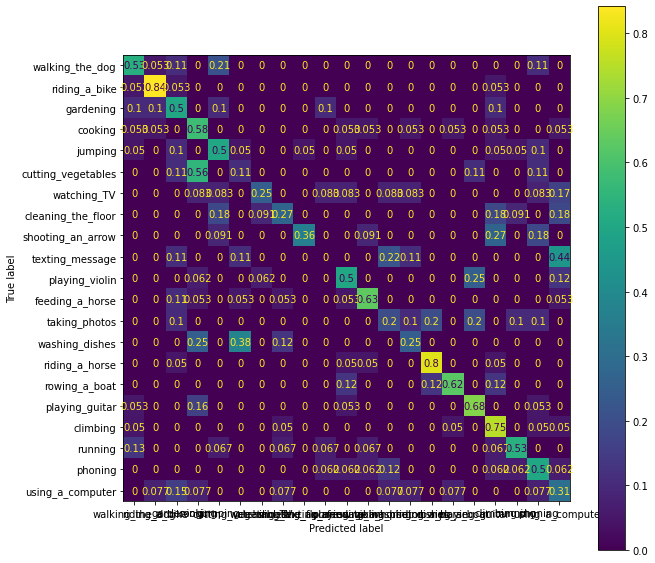

In [ ]:
performance_action(resnet_34_aug_model,validation_generator_performance,action_list)

### Test performance

              precision    recall  f1-score   support

           0       0.79      0.64      0.70        58
           1       0.78      0.73      0.76        93
           2       0.58      0.67      0.62        57
           3       0.61      0.67      0.63        60
           4       0.65      0.69      0.67        35

    accuracy                           0.68       303
   macro avg       0.68      0.68      0.68       303
weighted avg       0.69      0.68      0.69       303



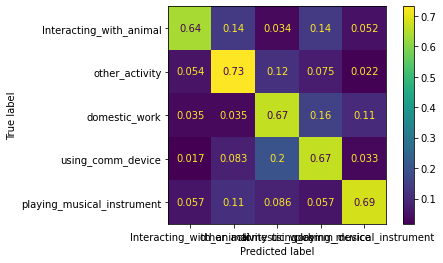

In [ ]:
performance_class(resnet_34_aug_model,test_generator,actionclass_list)

              precision    recall  f1-score   support

           0       0.44      0.37      0.40        19
           1       0.75      0.63      0.69        19
           2       0.44      0.40      0.42        10
           3       0.23      0.32      0.27        19
           4       0.47      0.37      0.41        19
           5       0.29      0.44      0.35         9
           6       0.62      0.42      0.50        12
           7       0.50      0.64      0.56        11
           8       0.60      0.27      0.37        11
           9       0.00      0.00      0.00         9
          10       0.40      0.38      0.39        16
          11       0.50      0.32      0.39        19
          12       0.38      0.30      0.33        10
          13       0.22      0.25      0.24         8
          14       0.70      0.70      0.70        20
          15       0.50      0.44      0.47         9
          16       0.72      0.68      0.70        19
          17       0.58    

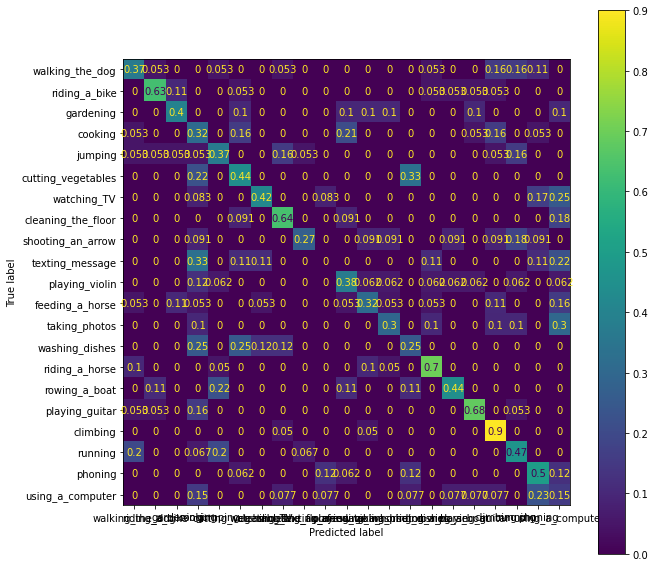

In [ ]:
performance_action(resnet_34_aug_model,test_generator,action_list)

* Test performance of Resnet-34 with augmentation is **0.68 macro-f1 score** of action class classification task and **0.42 macro-f1 score** on action classification.
* The performance is better than base modelin both tasks.

# Regularisation with augmantation


In [ ]:
def get_callbacks_with_earlystop(name,early_stop = True,save_best_only=False):
  if early_stop:
    checkpoint = './drive/My Drive/training_checkpoints'
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_{epoch:02d}")
    model_checkpoint_callback = ModelCheckpoint(
              filepath=checkpoint_filepath,
              save_weights_only=True,
              save_best_only=False)
    return model_checkpoint_callback
  
  else:
    checkpoint = './drive/My Drive/training_checkpoints'
    #checkpoint_filepath = os.path.join(checkpoint, "checkpoint_{epoch:02d}")
    checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_{epoch:02d}")
    model_checkpoint_callback = ModelCheckpoint(
              filepath=checkpoint_filepath,
              save_weights_only=True,
              save_best_only=False)
    return model_checkpoint_callback

In [ ]:
gen_list = [training_generator,augment_generator]

## lambda = 0.05

In [ ]:
h_histories = {}
gen_list = [training_generator,augment_generator]
reg_with_aug = get_resnet_model([64,128,256,512], [3,4,6,3], reg_lambda=0.05)
reg_with_aug.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum= 0.9),
                      #optimizer='SGD',
                      loss={'y_action': 'categorical_crossentropy', 'y_action_class': 'categorical_crossentropy'},
                      metrics={'y_action': tfa.metrics.F1Score(num_classes=21, average='macro'),
                      'y_action_class': tfa.metrics.F1Score(num_classes=5, average='macro')})
h_histories['reg_with_aug'+ '_h' + '0.05'] = reg_with_aug.fit(combine_gen(gen_list), 
                                                          epochs=25, 
                                                          steps_per_epoch=len(training_generator)*len(gen_list),
                                                          validation_data=validation_generator,
                                                          validation_steps=len(validation_generator), 
                                                          verbose=0, 
                                                          callbacks=get_callbacks('models/resnet_test_h_0.05'))

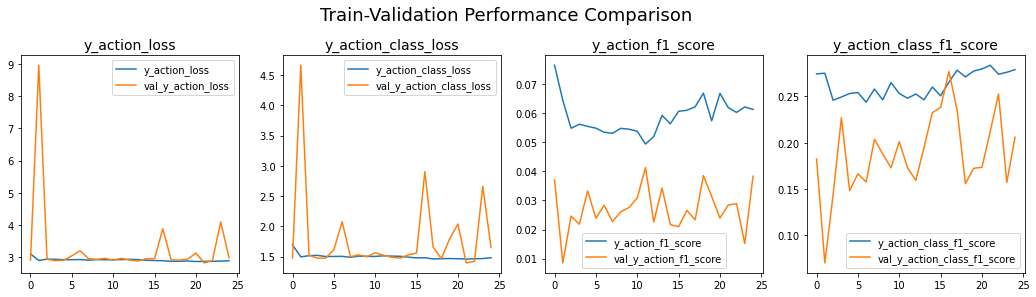

In [ ]:
plot_validation_performance(h_histories['reg_with_aug_h0.05'])

* lambda = 0.05 is too big the result shows model cannot reduce loss in both task after 25 epochs of training
* Next reduce lambda to 0.001

## lambda = 0.001

In [ ]:
reg_with_aug = get_resnet_model([64,128,256,512], [3,4,6,3], reg_lambda=0.001)
reg_with_aug.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum= 0.9),
                      #optimizer='SGD',
                      loss={'y_action': 'categorical_crossentropy', 'y_action_class': 'categorical_crossentropy'},
                      metrics={'y_action': tfa.metrics.F1Score(num_classes=21, average='macro'),
                      'y_action_class': tfa.metrics.F1Score(num_classes=5, average='macro')})


In [ ]:
h_histories_001 = reg_with_aug.fit(combine_gen(gen_list),
                                     epochs=25, 
                                     steps_per_epoch=len(training_generator)*len(gen_list),
                                     validation_data=validation_generator,
                                     validation_steps=len(validation_generator), 
                                     #verbose=0, 
                                     callbacks=get_callbacks('models/resnet_test_h_0.001'))

Epoch 1/25
150/150 [==============================] - 197s 1s/step - loss: 20.6249 - y_action_loss: 2.7936 - y_action_class_loss: 1.4525 - y_action_f1_score: 0.1165 - y_action_class_f1_score: 0.3268 - val_loss: 19.9553 - val_y_action_loss: 2.6572 - val_y_action_class_loss: 1.3993 - val_y_action_f1_score: 0.1195 - val_y_action_class_f1_score: 0.3154
Epoch 2/25
150/150 [==============================] - 196s 1s/step - loss: 19.3284 - y_action_loss: 2.5675 - y_action_class_loss: 1.3179 - y_action_f1_score: 0.1577 - y_action_class_f1_score: 0.3947 - val_loss: 18.9770 - val_y_action_loss: 2.6472 - val_y_action_class_loss: 1.3381 - val_y_action_f1_score: 0.1425 - val_y_action_class_f1_score: 0.3574
Epoch 3/25
150/150 [==============================] - 197s 1s/step - loss: 18.2673 - y_action_loss: 2.4371 - y_action_class_loss: 1.2652 - y_action_f1_score: 0.1950 - y_action_class_f1_score: 0.4271 - val_loss: 18.1779 - val_y_action_loss: 2.6292 - val_y_action_class_loss: 1.4064 - val_y_action_f1

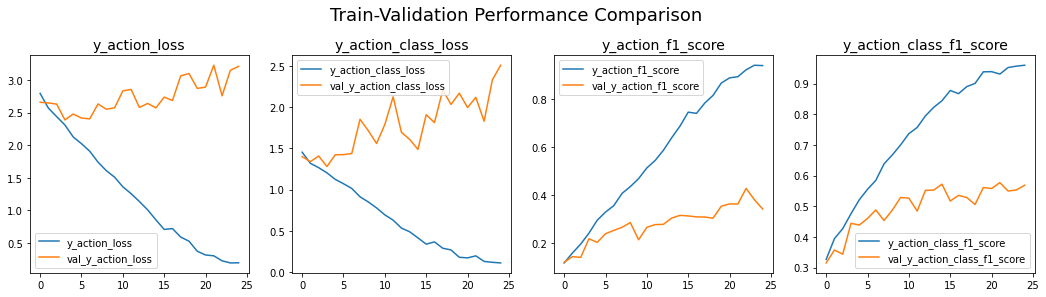

In [ ]:
plot_validation_performance(h_histories_001)

* Lambda = 0.001 is too small. The result shows significant overfitting 
* The best validation preformance is val_y_action_f1_score is around 0.4 and val_y_action_class_f1_score is around 0.57.
* Next try reduce lambda, the value should be between 0.001 and 0.05.
* try lambda = 0.005

## lambda = 0.005

In [ ]:
reg_with_aug = get_resnet_model([64,128,256,512], [3,4,6,3], reg_lambda=0.005)
reg_with_aug.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum= 0.9),
                      #optimizer='SGD',
                      loss={'y_action': 'categorical_crossentropy', 'y_action_class': 'categorical_crossentropy'},
                      metrics={'y_action': tfa.metrics.F1Score(num_classes=21, average='macro'),
                      'y_action_class': tfa.metrics.F1Score(num_classes=5, average='macro')})
h_histories['resnet_with_aug'+ '_h' + '0.005'] = reg_with_aug.fit(combine_gen(gen_list), 
                                                          epochs=25, 
                                                          steps_per_epoch=len(training_generator)*len(gen_list),
                                                          validation_data=validation_generator,
                                                          validation_steps=len(validation_generator), 
                                                          verbose=0, 
                                                          callbacks=get_callbacks('models/resnet_test_h_0.005'))

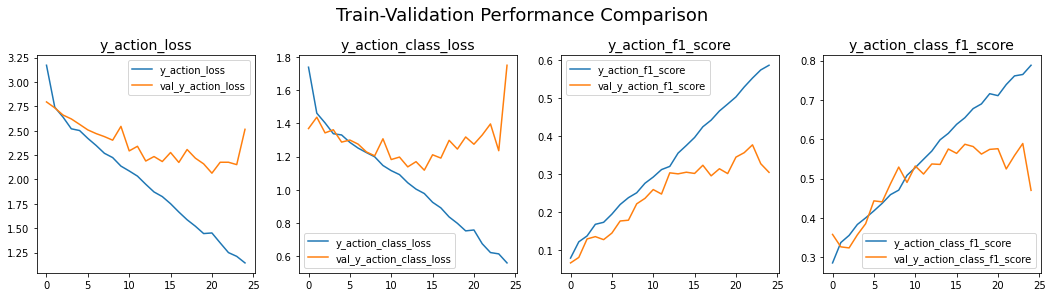

In [ ]:
plot_validation_performance(h_histories['resnet_with_aug'+ '_h' + '0.005'])

* The result is less overfitting previous model (lambda = 0.001) but still shown some overfitting.
* The best validation preformance is val_y_action_f1_score is around 0.37 and val_y_action_class_f1_score is around 0.57.
* Next, increase lambda to more than 0.005 and less than 0.05.
* Try lambda = 0.01

## lambda = 0.01

In [ ]:
h_histories={}
reg_with_aug = get_resnet_model([64,128,256,512], [3,4,6,3], reg_lambda=0.01)
reg_with_aug.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum= 0.9),
                      #optimizer='SGD',
                      loss={'y_action': 'categorical_crossentropy', 'y_action_class': 'categorical_crossentropy'},
                      metrics={'y_action': tfa.metrics.F1Score(num_classes=21, average='macro'),
                      'y_action_class': tfa.metrics.F1Score(num_classes=5, average='macro')})
h_histories['resnet_with_aug'+ '_h' + '0.01'] = reg_with_aug.fit(combine_gen(gen_list), 
                                                          epochs=25, 
                                                          steps_per_epoch=len(training_generator)*len(gen_list),
                                                          validation_data=validation_generator,
                                                          validation_steps=len(validation_generator), 
                                                          #verbose=0, 
                                                          callbacks=get_callbacks('models/resnet_test_h_0.01'))

Epoch 1/25
150/150 [==============================] - 204s 1s/step - loss: 138.5368 - y_action_loss: 3.0167 - y_action_class_loss: 1.6175 - y_action_f1_score: 0.0953 - y_action_class_f1_score: 0.2877 - val_loss: 102.8593 - val_y_action_loss: 3.6685 - val_y_action_class_loss: 1.8392 - val_y_action_f1_score: 0.0666 - val_y_action_class_f1_score: 0.3854
Epoch 2/25
150/150 [==============================] - 197s 1s/step - loss: 77.1843 - y_action_loss: 2.7268 - y_action_class_loss: 1.4055 - y_action_f1_score: 0.1152 - y_action_class_f1_score: 0.3413 - val_loss: 56.9917 - val_y_action_loss: 2.6986 - val_y_action_class_loss: 1.3306 - val_y_action_f1_score: 0.0832 - val_y_action_class_f1_score: 0.4129
Epoch 3/25
150/150 [==============================] - 197s 1s/step - loss: 43.8112 - y_action_loss: 2.6287 - y_action_class_loss: 1.3695 - y_action_f1_score: 0.1395 - y_action_class_f1_score: 0.3597 - val_loss: 32.7949 - val_y_action_loss: 2.5932 - val_y_action_class_loss: 1.2663 - val_y_action_

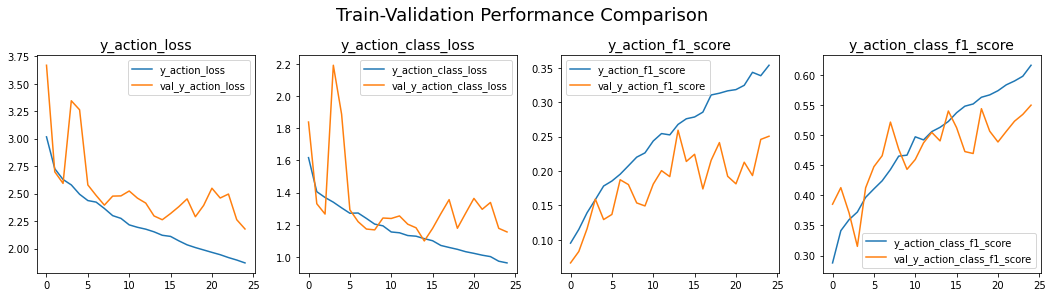

In [ ]:
plot_validation_performance(h_histories['resnet_with_aug'+ '_h' + '0.01'])

* The result show model is not overfitting after 25 epochs (validation still increasing).
* I decided to train the model 25 more epochs.

In [ ]:
h_histories['resnet_with_aug'+ '_h' + '0.01'] = reg_with_aug.fit(combine_gen(gen_list), 
                                                          epochs=25, 
                                                          steps_per_epoch=len(training_generator)*len(gen_list),
                                                          validation_data=validation_generator,
                                                          validation_steps=len(validation_generator), 
                                                          #verbose=0, 
                                                          callbacks=get_callbacks('models/resnet_test_h_0.01_2'))

Epoch 1/25
150/150 [==============================] - 197s 1s/step - loss: 3.9760 - y_action_loss: 1.8704 - y_action_class_loss: 0.9557 - y_action_f1_score: 0.3554 - y_action_class_f1_score: 0.6178 - val_loss: 5.1101 - val_y_action_loss: 2.4687 - val_y_action_class_loss: 1.4683 - val_y_action_f1_score: 0.2106 - val_y_action_class_f1_score: 0.5119
Epoch 2/25
150/150 [==============================] - 197s 1s/step - loss: 3.9351 - y_action_loss: 1.8278 - y_action_class_loss: 0.9317 - y_action_f1_score: 0.3729 - y_action_class_f1_score: 0.6327 - val_loss: 4.7990 - val_y_action_loss: 2.2951 - val_y_action_class_loss: 1.3249 - val_y_action_f1_score: 0.2714 - val_y_action_class_f1_score: 0.5343
Epoch 3/25
150/150 [==============================] - 197s 1s/step - loss: 3.9513 - y_action_loss: 1.8226 - y_action_class_loss: 0.9270 - y_action_f1_score: 0.3651 - y_action_class_f1_score: 0.6214 - val_loss: 4.4934 - val_y_action_loss: 2.1718 - val_y_action_class_loss: 1.0968 - val_y_action_f1_score

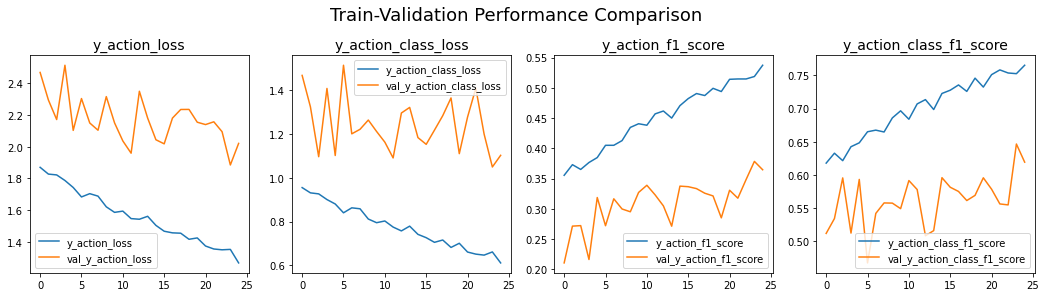

In [ ]:
plot_validation_performance(h_histories['resnet_with_aug'+ '_h' + '0.01'])

* The result look not too much overfitting.
* The best validation preformance is val_y_action_f1_score is around 0.37 and val_y_action_class_f1_score is around 0.64.
* Thus, I decided to use lambda = 0.01 for regularization because, it make model not overfitting too much and shows the best result compare to lambda 0.05, 0.001, 0.005 and 0.01 on validation set

In [ ]:
gen_list = [training_generator,augment_generator]
reg_with_aug = get_resnet_model([64,128,256,512], [3,4,6,3], reg_lambda=0.01)
reg_with_aug.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum= 0.9),
                      #optimizer='SGD',
                      loss={'y_action': 'categorical_crossentropy', 'y_action_class': 'categorical_crossentropy'},
                      metrics={'y_action': tfa.metrics.F1Score(num_classes=21, average='macro'),
                      'y_action_class': tfa.metrics.F1Score(num_classes=5, average='macro')})

In [ ]:
name = 'models/resnet_test_h_0.01_2'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_24")
reg_with_aug.load_weights(checkpoint_filepath)

### Validation performance

              precision    recall  f1-score   support

           0       0.60      0.60      0.60        58
           1       0.78      0.73      0.76        93
           2       0.63      0.60      0.61        57
           3       0.61      0.58      0.60        60
           4       0.55      0.74      0.63        35

    accuracy                           0.65       303
   macro avg       0.64      0.65      0.64       303
weighted avg       0.66      0.65      0.65       303



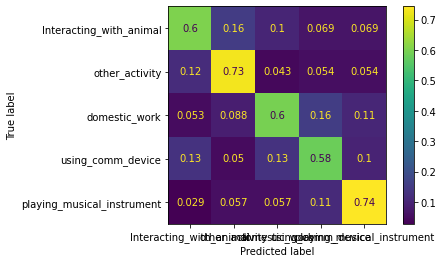

In [ ]:
performance_class(reg_with_aug,validation_generator_performance,actionclass_list)

              precision    recall  f1-score   support

           0       0.57      0.21      0.31        19
           1       0.74      0.74      0.74        19
           2       0.33      0.50      0.40        10
           3       0.67      0.53      0.59        19
           4       0.58      0.35      0.44        20
           5       0.00      0.00      0.00         9
           6       0.33      0.25      0.29        12
           7       0.29      0.36      0.32        11
           8       0.50      0.09      0.15        11
           9       0.00      0.00      0.00         9
          10       0.47      0.50      0.48        16
          11       0.42      0.58      0.49        19
          12       0.50      0.10      0.17        10
          13       0.20      0.12      0.15         8
          14       0.61      0.70      0.65        20
          15       0.50      0.62      0.56         8
          16       0.65      0.58      0.61        19
          17       0.59    

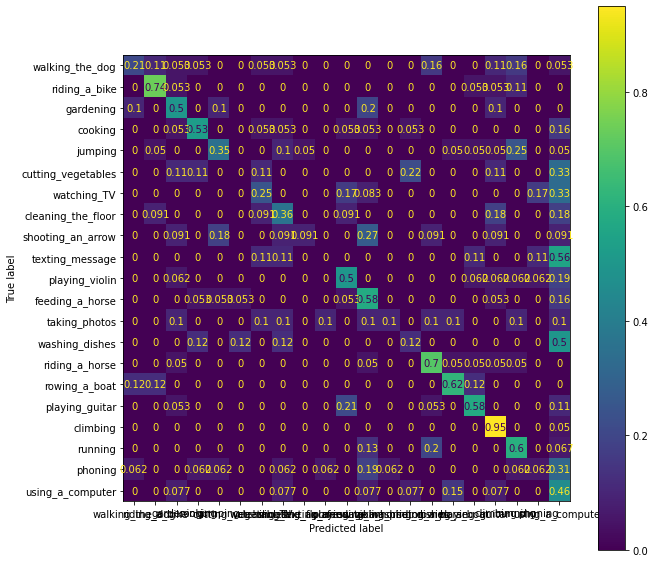

In [ ]:
performance_action(reg_with_aug,validation_generator_performance,action_list)

### Test performance

              precision    recall  f1-score   support

           0       0.65      0.57      0.61        58
           1       0.75      0.75      0.75        93
           2       0.58      0.53      0.55        57
           3       0.55      0.57      0.56        60
           4       0.53      0.69      0.60        35

    accuracy                           0.63       303
   macro avg       0.61      0.62      0.61       303
weighted avg       0.63      0.63      0.63       303



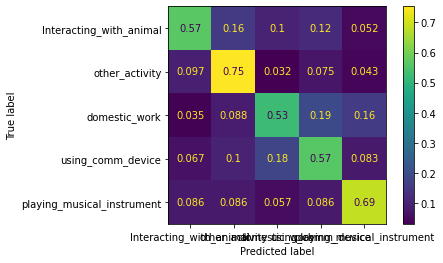

In [ ]:
performance_class(reg_with_aug,test_generator,actionclass_list)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.71      0.26      0.38        19
           1       0.80      0.42      0.55        19
           2       0.64      0.70      0.67        10
           3       0.54      0.37      0.44        19
           4       0.38      0.32      0.34        19
           5       0.40      0.22      0.29         9
           6       0.29      0.17      0.21        12
           7       0.57      0.73      0.64        11
           8       0.33      0.18      0.24        11
           9       0.00      0.00      0.00         9
          10       0.47      0.50      0.48        16
          11       0.33      0.32      0.32        19
          12       0.00      0.00      0.00        10
          13       0.50      0.25      0.33         8
          14       0.56      0.70      0.62        20
          15       0.50      0.56      0.53         9
          16       0.53      0.53      0.53        19
          17       0.59    

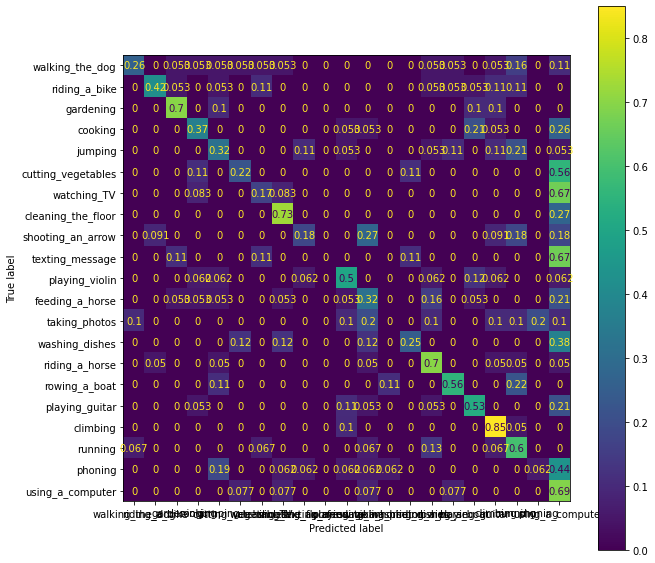

In [ ]:
performance_action(reg_with_aug,test_generator,action_list)

* Test performance of Resnet-34 with L2 regularisation (lambda =0.01) training on augmentation dataset is **0.61 macro-f1 score** of action class classification task and **0.38 macro-f1 score** on action classification.
* This model is better than base model but worse than Resnet-34 with augmentation on both tasks.
* After augmentation and regualrization, next I try to reduce model capacity by using Resnet-18

# Reduce model capacity

### Resnet-18 with augmentation


In [ ]:
resnet_18_aug = get_resnet_model([64,128,256,512], [2,2,2,2])
resnet_18_aug.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum= 0.9),
                     #optimizer='SGD',
                     loss={'y_action': 'categorical_crossentropy', 'y_action_class': 'categorical_crossentropy'},
                     metrics={'y_action': tfa.metrics.F1Score(num_classes=21, average='macro'),
                    'y_action_class': tfa.metrics.F1Score(num_classes=5, average='macro')})

In [ ]:
gen_list = [training_generator,augment_generator]
epochs = 40
history_resnet_18_aug= resnet_18_aug.fit(combine_gen(gen_list),epochs=epochs,steps_per_epoch=len(training_generator)*len(gen_list), 
                  validation_data=validation_generator,
                  validation_steps=len(validation_generator),  
                  callbacks=[get_callbacks('models/resnet_18_aug')])

Epoch 1/40
150/150 [==============================] - 176s 934ms/step - loss: 4.5491 - y_action_loss: 2.9587 - y_action_class_loss: 1.5904 - y_action_f1_score: 0.1043 - y_action_class_f1_score: 0.3012 - val_loss: 4.6206 - val_y_action_loss: 2.8341 - val_y_action_class_loss: 1.7865 - val_y_action_f1_score: 0.0687 - val_y_action_class_f1_score: 0.2531
Epoch 2/40
150/150 [==============================] - 138s 919ms/step - loss: 4.0216 - y_action_loss: 2.6367 - y_action_class_loss: 1.3849 - y_action_f1_score: 0.1529 - y_action_class_f1_score: 0.3668 - val_loss: 4.1862 - val_y_action_loss: 2.6861 - val_y_action_class_loss: 1.5001 - val_y_action_f1_score: 0.1277 - val_y_action_class_f1_score: 0.3760
Epoch 3/40
150/150 [==============================] - 139s 925ms/step - loss: 3.7851 - y_action_loss: 2.4765 - y_action_class_loss: 1.3087 - y_action_f1_score: 0.1985 - y_action_class_f1_score: 0.4173 - val_loss: 3.9777 - val_y_action_loss: 2.5913 - val_y_action_class_loss: 1.3864 - val_y_action

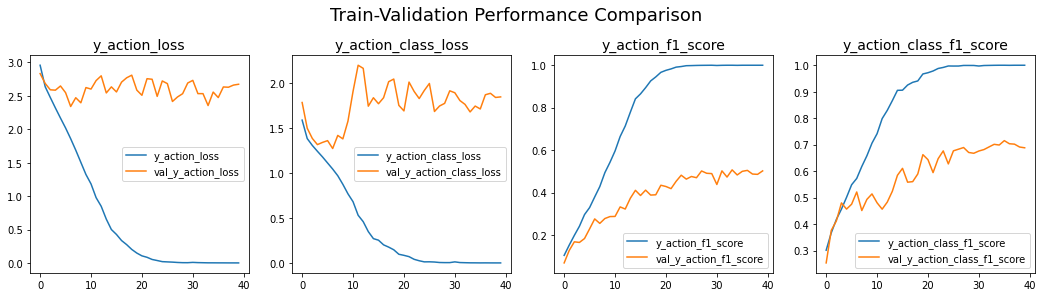

In [ ]:
plot_validation_performance(history_resnet_18_aug)

In [ ]:
name = 'models/resnet_18_aug'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_36")
resnet_18_aug.load_weights(checkpoint_filepath)

### Validation Performance

              precision    recall  f1-score   support

           0       0.78      0.67      0.72        58
           1       0.72      0.76      0.74        93
           2       0.63      0.65      0.64        57
           3       0.67      0.70      0.68        60
           4       0.79      0.74      0.76        35

    accuracy                           0.71       303
   macro avg       0.72      0.71      0.71       303
weighted avg       0.71      0.71      0.71       303



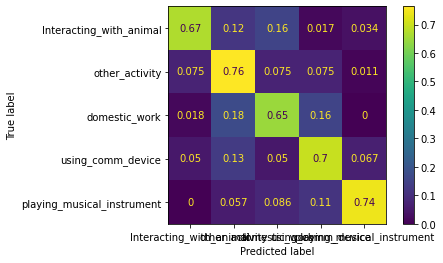

In [ ]:
performance_class(resnet_18_aug,validation_generator_performance,actionclass_list)

              precision    recall  f1-score   support

           0       0.60      0.47      0.53        19
           1       0.70      0.84      0.76        19
           2       0.45      0.50      0.48        10
           3       0.58      0.74      0.65        19
           4       0.71      0.60      0.65        20
           5       0.43      0.33      0.38         9
           6       0.67      0.33      0.44        12
           7       0.30      0.27      0.29        11
           8       0.67      0.36      0.47        11
           9       0.12      0.11      0.12         9
          10       0.53      0.50      0.52        16
          11       0.63      0.63      0.63        19
          12       0.33      0.20      0.25        10
          13       0.23      0.38      0.29         8
          14       0.67      0.70      0.68        20
          15       0.60      0.75      0.67         8
          16       0.75      0.79      0.77        19
          17       0.54    

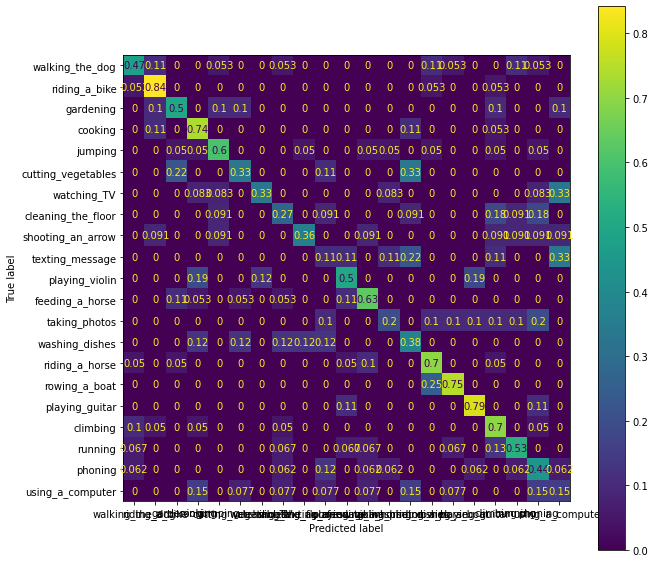

In [ ]:
performance_action(resnet_18_aug,validation_generator_performance,action_list)

### Test Performance

              precision    recall  f1-score   support

           0       0.69      0.59      0.64        58
           1       0.74      0.69      0.72        93
           2       0.57      0.67      0.61        57
           3       0.63      0.67      0.65        60
           4       0.63      0.69      0.66        35

    accuracy                           0.66       303
   macro avg       0.65      0.66      0.65       303
weighted avg       0.67      0.66      0.66       303



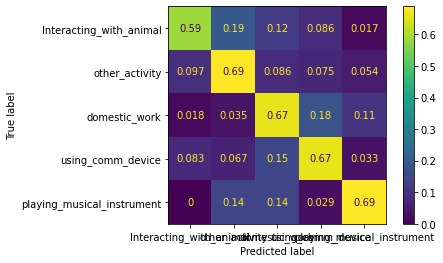

In [ ]:
performance_class(resnet_18_aug,test_generator,actionclass_list)

              precision    recall  f1-score   support

           0       0.56      0.47      0.51        19
           1       0.59      0.53      0.56        19
           2       0.50      0.30      0.37        10
           3       0.26      0.32      0.29        19
           4       0.43      0.53      0.48        19
           5       0.33      0.33      0.33         9
           6       0.78      0.58      0.67        12
           7       0.60      0.55      0.57        11
           8       0.33      0.09      0.14        11
           9       0.00      0.00      0.00         9
          10       0.42      0.50      0.46        16
          11       0.40      0.32      0.35        19
          12       0.33      0.40      0.36        10
          13       0.11      0.25      0.15         8
          14       0.73      0.80      0.76        20
          15       0.60      0.33      0.43         9
          16       0.63      0.63      0.63        19
          17       0.70    

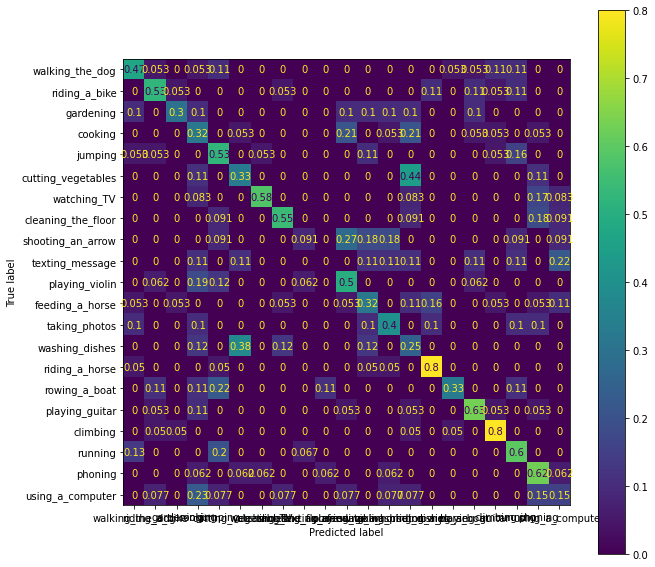

In [ ]:
performance_action(resnet_18_aug,test_generator,action_list)

* Test performance of Resnet-18 with augmentation is **0.65 macro-f1 score** of action class classification task and **0.43 macro-f1 score** on action classification.
* Resnet-18 have worse performance on action class classification task than Resnnet-34 but have better performance on action classification.
* According to the result, it seem to be action class classification task have better result on more complex model (resnet-34) while action classification have better performance on simpler model.
* Thus, I decided to add 3 more residual blocks only on action class classification path to add complexity only on action class classification task.

#Resnet extened


In [ ]:
def get_resnet_model_extened(filters, block_size, reg_lambda=0.0, fdropout=False,input_shape = 64):
  input = tf.keras.layers.Input(shape=(input_shape, input_shape, 3))

  x = tf.keras.layers.Conv2D(filters=64,
                                   kernel_size=(7, 7),
                                   strides=1,
                                   kernel_initializer="he_normal",
                                   kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                   padding="same")(input)

  x = tf.keras.layers.BatchNormalization(momentum=.4)(x)

  #Stack of residual blocks
  for nFilters, nBlocks in zip(filters, block_size):
    x = ResidualBlock(nFilters, stride=2, reg_lambda=reg_lambda)(x)
    
    for _ in range(1, nBlocks):
     x = ResidualBlock(nFilters, stride=1, reg_lambda=reg_lambda)(x)

  # final part
  #action class adding 3 of residual block only for action task
  x_class = ResidualBlock(512,stride=2, reg_lambda=reg_lambda)(x)
  x_class = ResidualBlock(512,stride=1, reg_lambda=reg_lambda)(x_class)
  x_class = ResidualBlock(512,stride=1, reg_lambda=reg_lambda)(x_class)
  x_class = tf.keras.layers.GlobalAveragePooling2D()(x_class)
  x_class = tf.keras.layers.Flatten()(x_class)
  
  y_action_class = tf.keras.layers.Dense(5,activation=tf.nn.softmax,
                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                            kernel_initializer="he_normal",name='y_action_class')(x_class)

  #action
  x_action = tf.keras.layers.GlobalAveragePooling2D()(x)
  x_action = tf.keras.layers.Flatten()(x_action)
  y_action = tf.keras.layers.Dense(21,activation=tf.nn.softmax,
                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                            kernel_initializer="he_normal",name ='y_action')(x_action)
  
  model = Model(inputs=input, outputs=[y_action, y_action_class])

  return model

In [ ]:
extended_resnet = get_resnet_model_extened([64,128,256,512], [2,2,2,2])
extended_resnet.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum= 0.9),
                     #optimizer='SGD',
                     loss={'y_action': 'categorical_crossentropy', 'y_action_class': 'categorical_crossentropy'},
                     metrics={'y_action': tfa.metrics.F1Score(num_classes=21, average='macro'),
                    'y_action_class': tfa.metrics.F1Score(num_classes=5, average='macro')})

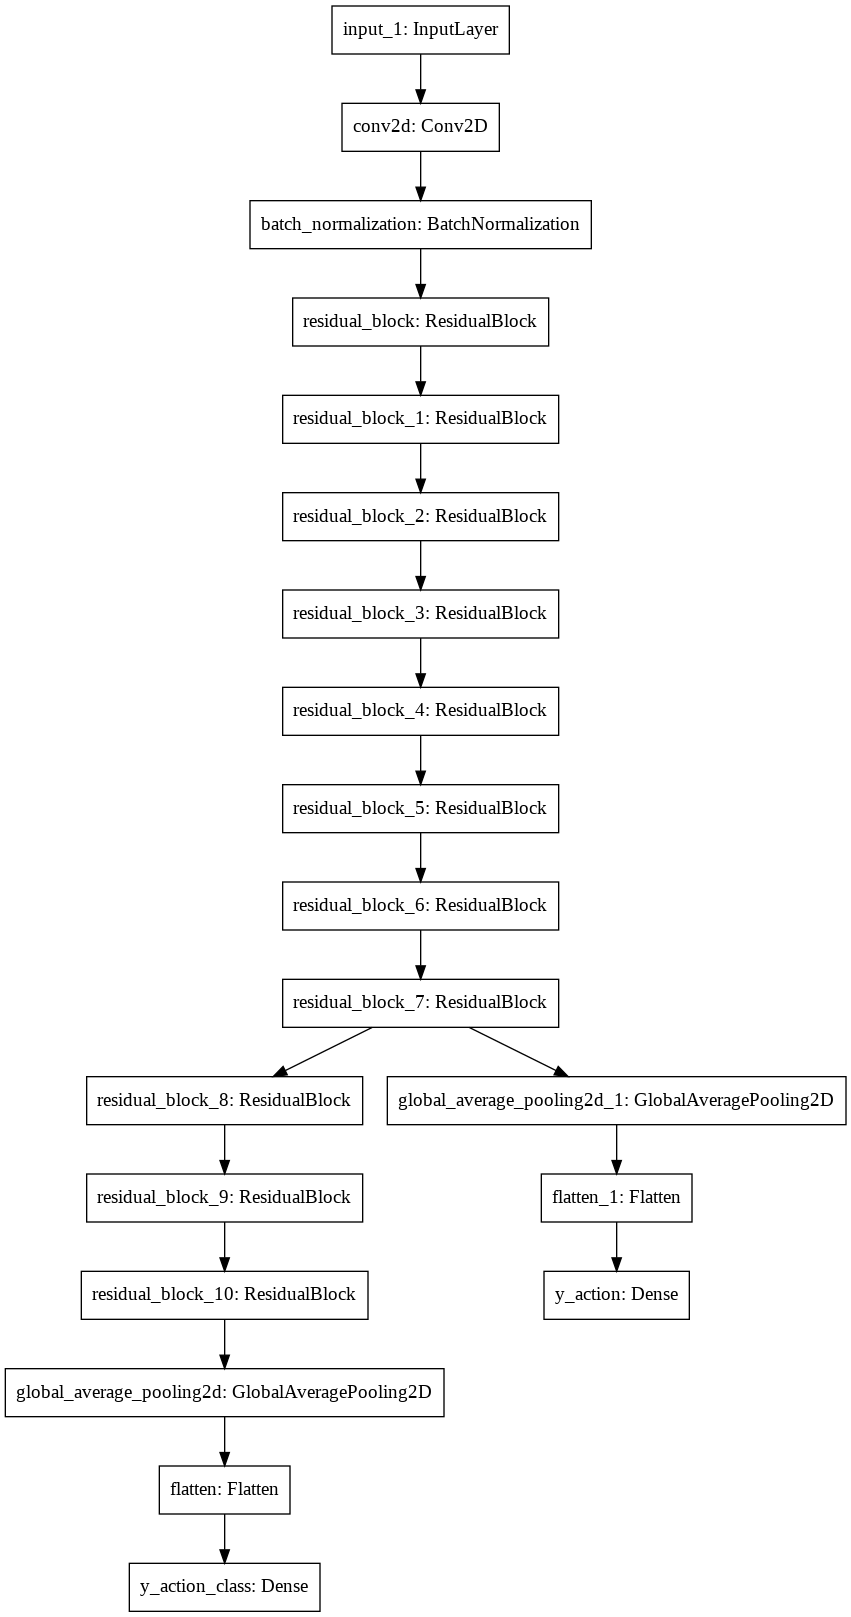

In [ ]:
tf.keras.utils.plot_model(extended_resnet)

In [ ]:
gen_list = [training_generator,augment_generator]
epochs = 50
extended_resnet_hist = extended_resnet.fit(combine_gen(gen_list),epochs=epochs,steps_per_epoch=len(training_generator)*len(gen_list), 
                  validation_data=validation_generator,
                  validation_steps=len(validation_generator),  
                  callbacks=[get_callbacks('models/extended_resnet')])

Epoch 1/50
150/150 [==============================] - 189s 1s/step - loss: 4.8041 - y_action_loss: 3.0505 - y_action_class_loss: 1.7536 - y_action_f1_score: 0.1049 - y_action_class_f1_score: 0.3062 - val_loss: 4.5551 - val_y_action_loss: 2.8943 - val_y_action_class_loss: 1.6608 - val_y_action_f1_score: 0.0720 - val_y_action_class_f1_score: 0.2313
Epoch 2/50
150/150 [==============================] - 150s 997ms/step - loss: 4.1219 - y_action_loss: 2.6781 - y_action_class_loss: 1.4437 - y_action_f1_score: 0.1504 - y_action_class_f1_score: 0.3671 - val_loss: 4.6130 - val_y_action_loss: 2.8489 - val_y_action_class_loss: 1.7641 - val_y_action_f1_score: 0.0956 - val_y_action_class_f1_score: 0.2315
Epoch 3/50
150/150 [==============================] - 150s 1s/step - loss: 3.7936 - y_action_loss: 2.4879 - y_action_class_loss: 1.3057 - y_action_f1_score: 0.2005 - y_action_class_f1_score: 0.4457 - val_loss: 4.2368 - val_y_action_loss: 2.7081 - val_y_action_class_loss: 1.5287 - val_y_action_f1_sc

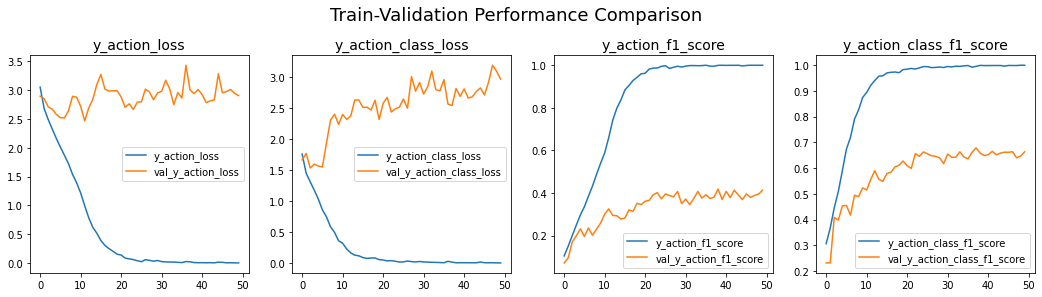

In [ ]:
plot_validation_performance(extended_resnet_hist)

In [ ]:
name = 'models/extended_resnet'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_39")
extended_resnet.load_weights(checkpoint_filepath)

### Validation Performance

              precision    recall  f1-score   support

           0       0.71      0.59      0.64        58
           1       0.71      0.72      0.72        93
           2       0.50      0.67      0.57        57
           3       0.71      0.62      0.66        60
           4       0.73      0.69      0.71        35

    accuracy                           0.66       303
   macro avg       0.67      0.66      0.66       303
weighted avg       0.67      0.66      0.66       303



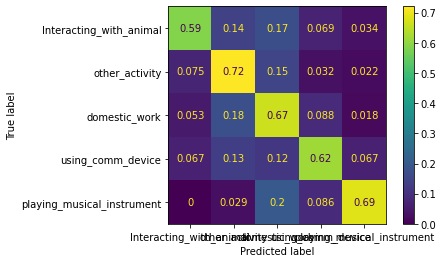

In [ ]:
performance_class(extended_resnet,validation_generator_performance,actionclass_list)

              precision    recall  f1-score   support

           0       0.53      0.47      0.50        19
           1       0.70      0.74      0.72        19
           2       0.40      0.40      0.40        10
           3       0.32      0.63      0.42        19
           4       0.53      0.40      0.46        20
           5       0.13      0.22      0.17         9
           6       0.83      0.42      0.56        12
           7       0.29      0.36      0.32        11
           8       0.60      0.27      0.37        11
           9       0.00      0.00      0.00         9
          10       0.45      0.31      0.37        16
          11       0.72      0.68      0.70        19
          12       0.43      0.30      0.35        10
          13       0.14      0.12      0.13         8
          14       0.64      0.70      0.67        20
          15       0.56      0.62      0.59         8
          16       0.52      0.58      0.55        19
          17       0.63    

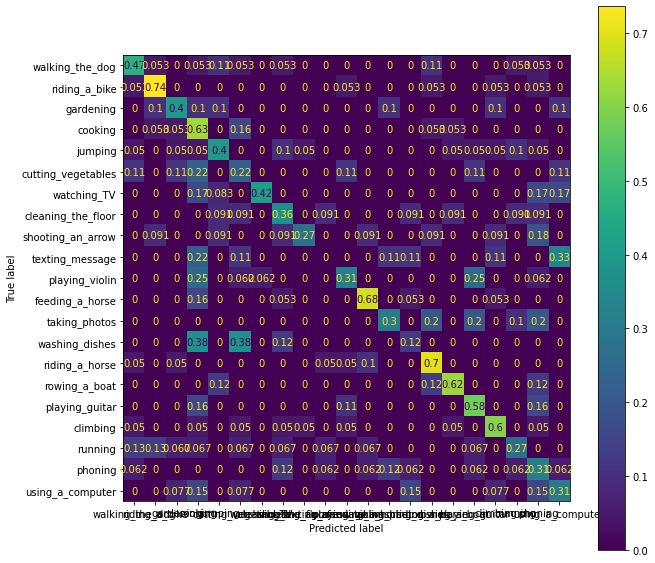

In [ ]:
performance_action(extended_resnet,validation_generator_performance,action_list)

### Test Performance

              precision    recall  f1-score   support

           0       0.67      0.55      0.60        58
           1       0.72      0.77      0.75        93
           2       0.54      0.67      0.59        57
           3       0.64      0.53      0.58        60
           4       0.74      0.71      0.72        35

    accuracy                           0.66       303
   macro avg       0.66      0.65      0.65       303
weighted avg       0.66      0.66      0.66       303



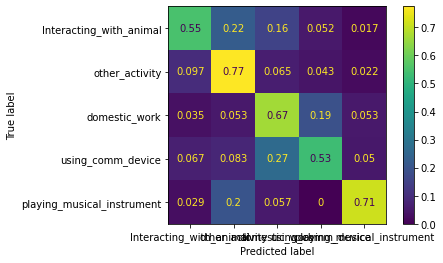

In [ ]:
performance_class(extended_resnet,test_generator,actionclass_list)

              precision    recall  f1-score   support

           0       0.53      0.47      0.50        19
           1       0.70      0.74      0.72        19
           2       0.40      0.40      0.40        10
           3       0.32      0.63      0.42        19
           4       0.53      0.40      0.46        20
           5       0.13      0.22      0.17         9
           6       0.83      0.42      0.56        12
           7       0.29      0.36      0.32        11
           8       0.60      0.27      0.37        11
           9       0.00      0.00      0.00         9
          10       0.45      0.31      0.37        16
          11       0.72      0.68      0.70        19
          12       0.43      0.30      0.35        10
          13       0.14      0.12      0.13         8
          14       0.64      0.70      0.67        20
          15       0.56      0.62      0.59         8
          16       0.52      0.58      0.55        19
          17       0.63    

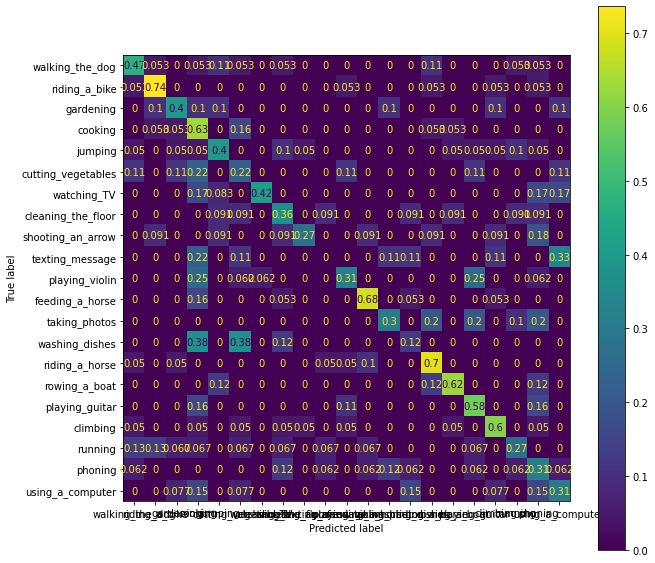

In [ ]:
performance_action(extended_resnet,validation_generator_performance,action_list)

* Test performance of Resnet-18 with extention is 0.65 macro-f1 score of action class classification task and 0.42 macro-f1 score on action classification.

* The model cannot achieve better performance of both Resnent-18 and Resnet-34 with augmentaion.

# Ultimate Judgement

## Action class classification

              precision    recall  f1-score   support

           0       0.46      0.60      0.52        58
           1       0.65      0.71      0.68        93
           2       0.51      0.39      0.44        57
           3       0.52      0.58      0.55        60
           4       0.67      0.29      0.40        35

    accuracy                           0.55       303
   macro avg       0.56      0.51      0.52       303
weighted avg       0.56      0.55      0.55       303



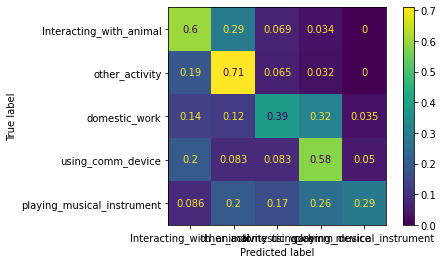

In [ ]:
#Resnet-34
performance_class(base_model,test_generator,actionclass_list)

              precision    recall  f1-score   support

           0       0.69      0.59      0.64        58
           1       0.74      0.69      0.72        93
           2       0.57      0.67      0.61        57
           3       0.63      0.67      0.65        60
           4       0.63      0.69      0.66        35

    accuracy                           0.66       303
   macro avg       0.65      0.66      0.65       303
weighted avg       0.67      0.66      0.66       303



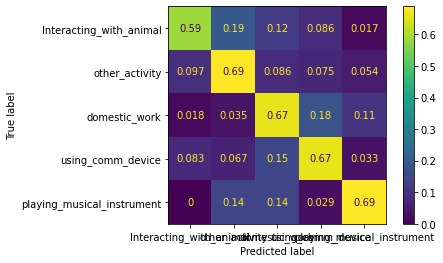

In [ ]:
#Resnet-18
performance_class(resnet_18_aug,test_generator,actionclass_list)

* The confusion matrices shows Resnet-34 with augmentation have better task 1 performance than Resnet-18 with augmentation on Interacting with animal and other activity and on tie with other classes. 

## Action classification

              precision    recall  f1-score   support

           0       0.31      0.42      0.36        19
           1       0.78      0.37      0.50        19
           2       0.23      0.30      0.26        10
           3       0.30      0.37      0.33        19
           4       0.36      0.47      0.41        19
           5       0.33      0.22      0.27         9
           6       0.43      0.25      0.32        12
           7       0.27      0.27      0.27        11
           8       0.00      0.00      0.00        11
           9       0.03      0.11      0.05         9
          10       0.40      0.12      0.19        16
          11       0.36      0.26      0.30        19
          12       0.11      0.10      0.11        10
          13       0.10      0.12      0.11         8
          14       0.44      0.60      0.51        20
          15       1.00      0.22      0.36         9
          16       0.50      0.37      0.42        19
          17       0.48    

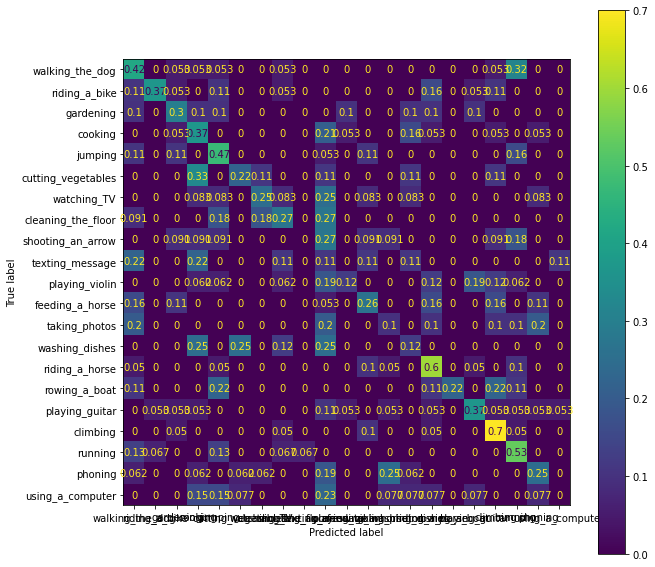

In [ ]:
# Resnet-34
performance_action(base_model,test_generator,action_list)

              precision    recall  f1-score   support

           0       0.56      0.47      0.51        19
           1       0.59      0.53      0.56        19
           2       0.50      0.30      0.37        10
           3       0.26      0.32      0.29        19
           4       0.43      0.53      0.48        19
           5       0.33      0.33      0.33         9
           6       0.78      0.58      0.67        12
           7       0.60      0.55      0.57        11
           8       0.33      0.09      0.14        11
           9       0.00      0.00      0.00         9
          10       0.42      0.50      0.46        16
          11       0.40      0.32      0.35        19
          12       0.33      0.40      0.36        10
          13       0.11      0.25      0.15         8
          14       0.73      0.80      0.76        20
          15       0.60      0.33      0.43         9
          16       0.63      0.63      0.63        19
          17       0.70    

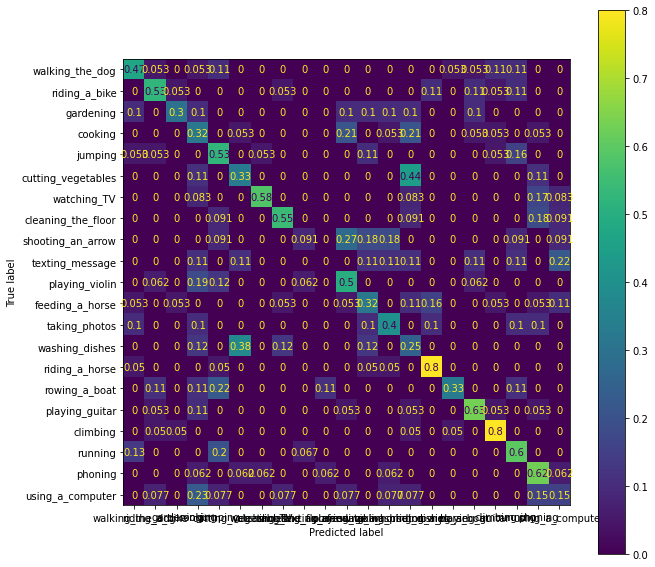

In [ ]:
#Resnet-18
performance_action(resnet_18_aug,test_generator,action_list)

* On task 2, Even Resnet-18 can achieve a bit higher macro F1-score than Resnet-34 (0.43 and 0.42) but the confusion matrix shows Resnet-18 have 2 classes that have nearly 0 detection (shooting an arrow and texting message) while, Resnet-34 have only texting message that model cannot predict correct.

## Conclusion
I decided to use Resnet-34 as my final model. Because, it have the highest performance on both tasks.

# Predicting on test set

In [ ]:
test = pd.read_csv('./S40AR_test_data.csv')

In [ ]:
#Create dummy action num
test['action_class_num'] = np.random.randint(0, 4, test.shape[0])
test['action_num'] =  np.random.randint(0, 20, test.shape[0])

In [ ]:
# drop error image
new_test = test.drop(test[(test['FileName'] == "Img_3201.jpg")].index)

In [ ]:
filename = list(test['FileName'])

In [ ]:
for i in filename:
  print(i)
  break

Img_1005.jpg


In [ ]:
prefix='./Images/'
filepath = prefix + 'Img_1005.jpg'
data = Image.open(filepath)
data = data.resize((224,224))
data = np.asarray(data)

In [ ]:
data_mean = 0.
data_std = 255.0
final_test_generator = DataGenerator(new_test,dim=(224, 224,3), batch_size=1, data_mean=data_mean, 
                                   data_std=data_std, n_action=21, n_action_class=5, Augment=False, data_prefix=prefix,shuffle = False)

In [ ]:
resnet_34_aug_model = get_resnet_model([64,128,256,512], [3,4,6,3])
resnet_34_aug_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum= 0.9),
                     #optimizer='SGD',
                     loss={'y_action': 'categorical_crossentropy', 'y_action_class': 'categorical_crossentropy'},
                     metrics={'y_action': tfa.metrics.F1Score(num_classes=21, average='macro'),
                    'y_action_class': tfa.metrics.F1Score(num_classes=5, average='macro')})

In [ ]:
#load weight of resnet-34 model
name = 'models/resnet_34_aug'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_37")
resnet_34_aug_model.load_weights(checkpoint_filepath)

In [ ]:
checkpoint_filepath

'./drive/My Drive/training_checkpoints/models/resnet_34_aug/checkpoint_37'

In [ ]:
y = resnet_34_aug_model.predict(final_test_generator)

In [ ]:
action_pred = np.argmax(y[0],axis=1)
class_pred = np.argmax(y[1],axis=1)

In [ ]:
action_prediction = []
for i in action_pred:
  action_prediction.append(action_list[i])

In [ ]:
class_prediction=[]
for i in class_pred:
  class_prediction.append(actionclass_list[i])

In [ ]:
new_test['action'] = action_prediction
new_test['action_class'] = class_prediction

In [ ]:
final_prediction = new_test.drop(['action_class_num','action_num'],axis=1)

In [ ]:
final_prediction.head()

FileName              action             action_class
0  Img_1005.jpg      riding_a_horse  Interacting_with_animal
1  Img_1012.jpg             cooking        using_comm_device
2  Img_1014.jpg  cutting_vegetables            domestic_work
3  Img_1015.jpg   shooting_an_arrow           other_activity
4   Img_102.jpg     texting_message        using_comm_device

In [ ]:
final_prediction.to_csv("./drive/My Drive/training_checkpoints/s3808216_predictions.csv")